# Предсказание сердечного приступа у пациента

# Цель исследования:

Разработать модель машинного обучения для предсказания на тестовой выборке риска возникновения сердечного приступа у пациента.

1. Исследование датасета
2. Предобработка данных
3. Обучение модели
4. Подготовка предсказания на тестовой выборке


# Описание данных

`heart_train.csv` - тренировочная выборка с данными пациентов

| Признак | Обозначение |
| ------- | ------- |
| `Age` | Возраст |
| `Cholesterol` | Холестерин |
| `Heart rate` | Сердечный ритм |
| `Diabetes` | Диабет |
| `Family History` | Семейный анамнез |
| `Smoking` | Курение |
| `Obesity` | Ожирение |
| `Alcohol Consumption` | Потребление алкоголя |
| `Exercise Hours Per Week` | Часы активности в неделю |
| `Diet` | Диета |
| `Previous Heart Problems` | Проблемы с сердцем ранее |
| `Medication Use` | Приём лекарств |
| `Stress Level` | Уровень стресса |
| `Sedentary Hours Per Day` | Сидячие часы в день |
| `Income` | Доход |
| `BMI` | Индекс массы тела |
| `Triglycerides` | Триглицериды |
| `Physical Activity Days Per Week` | Количество дней активности в неделю |
| `Sleep Hours Per Day` | Количество часов сна в день |
| `Heart Attack Risk (Binary)` | Риск сердечного приступа (бинарный) - целевой признак |
| `Blood sugar` | Содержание сахара в крови |
| `CK-MB` | Креатинкиназа-МВ |
| `Troponin` | Тропонин |
| `Gender` | Пол |
| `Systolic blood pressure` | Систолическое АД |
| `Diastolic blood pressure` | Диастолическое АД |
| `id` | Идентификатор пациента |

`heart_test.csv` - тестовая выборка с данными пациентов без целевого признака.

# Обзор данных

## Установка дополнительных библиотек

In [30]:
#!pip install catboost shap -q

## Импортирование библиотек

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from statistics import mode
import joblib
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm

from phik import phik_matrix

# Настройки отображения Pandas и графиков
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

## Загрузка данных

In [3]:
pth0 = '../datasets/heart_train.csv'
pth1 = '../datasets/heart_test.csv'

def load_data(local_path):
    if os.path.exists(local_path):
        return pd.read_csv(local_path)
    else:
        return 'Что-то пошло не так'

data_train = load_data(pth0)
data_test = load_data(pth1)

In [4]:
for name, df in [('data_train', data_train), ('data_test', data_test)]:
    f'\n{name}'
    display(df.head())
    display(df.info())
    display(df.describe())

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

None

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.00000,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,935.000000,935.000000,966.000000,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,482.50000,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,0.494118,0.488770,5.332620,0.506715,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822,4769.160455
std,279.00448,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,0.500233,0.500141,2.858466,0.287826,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935,2818.815407
min,0.00000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,1.000000,0.001187,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279,0.000000
25%,241.25000,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,0.000000,0.000000,3.000000,0.258713,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837,2275.750000
50%,482.50000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.000000,5.000000,0.501327,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372,4769.500000
75%,723.75000,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,1.000000,8.000000,0.759591,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535,7206.000000
max,965.00000,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,1.000000,1.000000,10.000000,0.999033,0.998885,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698,9644.000000


В датасетах выполнена нормализация или масштабирование признаков — почти все значения от 0 до 1, а некоторые категориальные признаки (Diet, Gender и др.) закодированы числами.

Unnamed: 0 — это индекс, лишний столбец, нужно удалить.

Много признаков с NaN — Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week.

Gender — категориальный (Male/Female), единственный текстовый. Нужно будет перевести в числовой (0, 1)

id — не используем для обучения. Также следует удалить.

Признаки необходимо привести к единому стилю.

# Предобработка данных

## Приведение именования столбцов к общей стилистике

In [5]:
data_train = data_train.drop(columns=['Unnamed: 0', 'id'])
data_test = data_test.drop(columns=['Unnamed: 0', 'id'])

def to_snake_case(name: str) -> str:
    """
    Функция приводит написание признаков к общему стилю
    """
    return (
        name.strip()
        .replace('(Binary)', '')
        .lower()
        .replace(' ', '_')
    )

In [6]:
data_train.columns = [to_snake_case(col) for col in data_train.columns]
data_test.columns = [to_snake_case(col) for col in data_test.columns]

display(data_train.columns.tolist())
display(data_test.columns.tolist())

['age',
 'cholesterol',
 'heart_rate',
 'diabetes',
 'family_history',
 'smoking',
 'obesity',
 'alcohol_consumption',
 'exercise_hours_per_week',
 'diet',
 'previous_heart_problems',
 'medication_use',
 'stress_level',
 'sedentary_hours_per_day',
 'income',
 'bmi',
 'triglycerides',
 'physical_activity_days_per_week',
 'sleep_hours_per_day',
 'heart_attack_risk_',
 'blood_sugar',
 'ck-mb',
 'troponin',
 'gender',
 'systolic_blood_pressure',
 'diastolic_blood_pressure']

['age',
 'cholesterol',
 'heart_rate',
 'diabetes',
 'family_history',
 'smoking',
 'obesity',
 'alcohol_consumption',
 'exercise_hours_per_week',
 'diet',
 'previous_heart_problems',
 'medication_use',
 'stress_level',
 'sedentary_hours_per_day',
 'income',
 'bmi',
 'triglycerides',
 'physical_activity_days_per_week',
 'sleep_hours_per_day',
 'blood_sugar',
 'ck-mb',
 'troponin',
 'gender',
 'systolic_blood_pressure',
 'diastolic_blood_pressure']

## Проверка на явные дубликаты

In [7]:
for df, name in [(data_train, "data_train"),
          (data_test, "data_test")]:
    
    duplicates = df.duplicated().sum()
    
    print(f"\nДатафрейм: {name}")
    display(duplicates)
    
    if duplicates > 0:
        duplicates = df[df.duplicated(keep=False)]
        display(duplicates)


Датафрейм: data_train


0


Датафрейм: data_test


0

Явных дубликатов нет.

## Проверка на неявные дубликаты

Единственный признак имеющий тип данных object - gender. Необходимо проверить его на неявные дубликаты.

In [8]:
data_train['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

In [9]:
data_test['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

В признаке gender содержатся значения: 'Male', 'Female', '1.0', '0.0'. Приведем его к формату int.

In [10]:
def normalize_gender(val):
    """
    Функция заменяет значения на 1 и 0.
    """
    val_str = str(val).lower()
    if val_str in ['male', '1.0']:
        return 1
    elif val_str in ['female', '0.0']:
        return 0

data_train['gender'] = data_train['gender'].apply(normalize_gender).astype('Int64')
data_test['gender'] = data_test['gender'].apply(normalize_gender).astype('Int64')

In [11]:
data_train['gender'].unique()

<IntegerArray>
[1, 0]
Length: 2, dtype: Int64

In [12]:
data_test['gender'].unique()

<IntegerArray>
[1, 0]
Length: 2, dtype: Int64

Также, проверим на неявные дубликаты остальные не закодированные признаки.

In [13]:
features = ['diabetes', 
            'family_history', 
            'smoking', 
            'obesity', 
            'alcohol_consumption', 
            'diet', 
            'previous_heart_problems', 
            'medication_use', 
            'stress_level', 
            'physical_activity_days_per_week']

for feature in features:
    print(feature)
    print(data_train[feature].unique())

diabetes
[ 1.  0. nan]
family_history
[ 1.  0. nan]
smoking
[ 1.  0. nan]
obesity
[ 1.  0. nan]
alcohol_consumption
[ 1.  0. nan]
diet
[1 2 0 3]
previous_heart_problems
[ 1.  0. nan]
medication_use
[ 0.  1. nan]
stress_level
[ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
physical_activity_days_per_week
[ 3.  2.  0.  5.  6.  4.  7. nan  1.]


В data_train у этих признаков есть значения nan, кроме признака diet. Необходимо заполнить проауски и привести к нужному типу данных.

In [14]:
for feature in features:
    print(feature)
    print(data_test[feature].unique())

diabetes
[ 0.  1. nan]
family_history
[ 1.  0. nan]
smoking
[ 1.  0. nan]
obesity
[ 1.  0. nan]
alcohol_consumption
[ 1.  0. nan]
diet
[2 0 1 3]
previous_heart_problems
[ 0.  1. nan]
medication_use
[ 0.  1. nan]
stress_level
[ 8.  5. 10.  7.  1.  4.  9.  6.  3. nan  2.]
physical_activity_days_per_week
[ 1.  0.  7.  5.  3.  2.  4.  6. nan]


В data_test необходимо провести аналогичную работу.

## Заполнение пропусков и изменение типов данных

In [15]:
binary_cols = [
    'diabetes', 'family_history', 'smoking', 'obesity',
    'alcohol_consumption', 'previous_heart_problems', 'medication_use'
]

for col in binary_cols:
    fill_val = data_train[col].mode(dropna=True)[0]
    data_train[col] = data_train[col].fillna(fill_val).astype('Int64')
    data_test[col] = data_test[col].fillna(fill_val).astype('Int64')

data_train['diet'] = data_train['diet'].astype('Int64')
data_test['diet'] = data_test['diet'].astype('Int64')

median_stress = int(data_train['stress_level'].median())
data_train['stress_level'] = data_train['stress_level'].fillna(median_stress).astype('Int64')
data_test['stress_level'] = data_test['stress_level'].fillna(median_stress).astype('Int64')

mode_activity = int(data_train['physical_activity_days_per_week'].mode(dropna=True)[0])
data_train['physical_activity_days_per_week'] = data_train['physical_activity_days_per_week'].fillna(mode_activity).astype('Int64')
data_test['physical_activity_days_per_week'] = data_test['physical_activity_days_per_week'].fillna(mode_activity).astype('Int64')


In [16]:
for feature in features:
    print(feature)
    print(data_train[feature].unique())
    
data_train.info()

diabetes
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
family_history
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
smoking
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
obesity
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
alcohol_consumption
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
diet
<IntegerArray>
[1, 2, 0, 3]
Length: 4, dtype: Int64
previous_heart_problems
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
medication_use
<IntegerArray>
[0, 1]
Length: 2, dtype: Int64
stress_level
<IntegerArray>
[8, 9, 6, 3, 7, 1, 10, 5, 2, 4]
Length: 10, dtype: Int64
physical_activity_days_per_week
<IntegerArray>
[3, 2, 0, 5, 6, 4, 7, 1]
Length: 8, dtype: Int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-n

In [17]:
for feature in features:
    print(feature)
    print(data_test[feature].unique())

data_test.info()

diabetes
<IntegerArray>
[0, 1]
Length: 2, dtype: Int64
family_history
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
smoking
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
obesity
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
alcohol_consumption
<IntegerArray>
[1, 0]
Length: 2, dtype: Int64
diet
<IntegerArray>
[2, 0, 1, 3]
Length: 4, dtype: Int64
previous_heart_problems
<IntegerArray>
[0, 1]
Length: 2, dtype: Int64
medication_use
<IntegerArray>
[0, 1]
Length: 2, dtype: Int64
stress_level
<IntegerArray>
[8, 5, 10, 7, 1, 4, 9, 6, 3, 2]
Length: 10, dtype: Int64
physical_activity_days_per_week
<IntegerArray>
[1, 0, 7, 5, 3, 2, 4, 6]
Length: 8, dtype: Int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null

Все пропуски были заполненны, признаки приведены к нужным типам данных.

## Промежуточный вывод

На этапе предобработки было выполненно следующее:
- Приведено именование столбцов к общей стилистике
- Проведена проверка на явные дубликаты (отсутствуют)
- Проведене проверка на неявные дубликаты в не закодированных признаках
- В признаке gender были изменены значения на 0 и 1, изменен тип данных на int
- В признаках 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week' были заполненны пропуски и изменен тип данных на int.

# Исследовательский анализ данных

## Определим функцию для построения гистограммы по определенному параметру и вывода основной статистики

In [18]:
def show_hist(data, column, bins=30):
    """
    Строит гистограмму и boxplot для указанного столбца DataFrame, 
    выводит основные статистические параметры, отмечает 99-й перцентиль,
    а также показывает количество значений, превышающих 99-й перцентиль, и их долю.

    params:
    data (DataFrame): Исходный датафрейм.
    column (str): Название признака для анализа.
    bins (int, optional): Количество бинов гистограммы. По умолчанию 30.

    return: None
    """
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Вычисление статистики
    percentile_99 = data[column].quantile(0.99)
    count_above_99 = data[data[column] > percentile_99][column].count()
    total_count = data[column].count()
    proportion_above_99 = count_above_99 / total_count
    
    print(f"\nСтатистика для '{column}':")
    print(f"Количество значений: {total_count}")
    print(f"Минимум: {data[column].min()}")
    print(f"Максимум: {data[column].max()}")
    print(f"Среднее: {data[column].mean():.2f}")
    print(f"Медиана: {data[column].median():.2f}")
    print(f"Стандартное отклонение: {data[column].std():.2f}")
    print(f"99-й перцентиль: {percentile_99:.2f}")
    print(f"Количество значений выше 99-го перцентиля: {count_above_99}")
    print(f"Доля значений выше 99-го перцентиля: {proportion_above_99:.2%}")

    # Создаём фигуру с 2 графиками: гистограмма + boxplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Гистограмма с линией 99-го перцентиля
    sns.histplot(data[column], bins=bins, kde=True, color="blue", alpha=0.7, ax=axes[0])
    axes[0].axvline(percentile_99, color='red', linestyle='dashed', linewidth=2, label="99-й перцентиль")
    axes[0].legend()
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Частота")
    axes[0].set_title(f"Гистограмма для '{column}'")
    axes[0].grid(True)

    # Boxplot
    sns.boxplot(x=data[column], ax=axes[1], color="lightblue")
    axes[1].axvline(percentile_99, color='red', linestyle='dashed', linewidth=2)
    axes[1].set_xlabel(column)
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()

## Анализ данных data_train

In [19]:
cat_features = [
    'gender',
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'diet',
    'previous_heart_problems',
    'medication_use',
    'stress_level',  
    'physical_activity_days_per_week'
]

num_features = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'sleep_hours_per_day',
    'blood_sugar',
    'ck-mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
]

target = 'heart_attack_risk_'

## Анализ числовых признаков 


Статистика для 'age':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.45
Медиана: 0.46
Стандартное отклонение: 0.23
99-й перцентиль: 0.85
Количество значений выше 99-го перцентиля: 4
Доля значений выше 99-го перцентиля: 0.05%


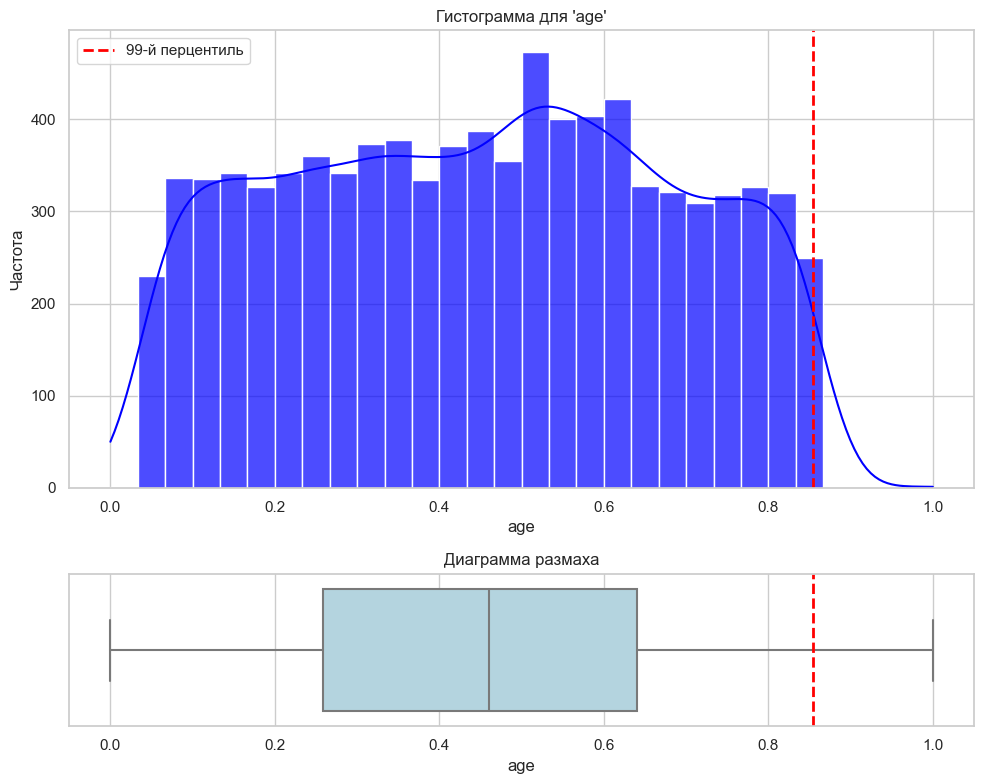


Статистика для 'cholesterol':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 71
Доля значений выше 99-го перцентиля: 0.82%


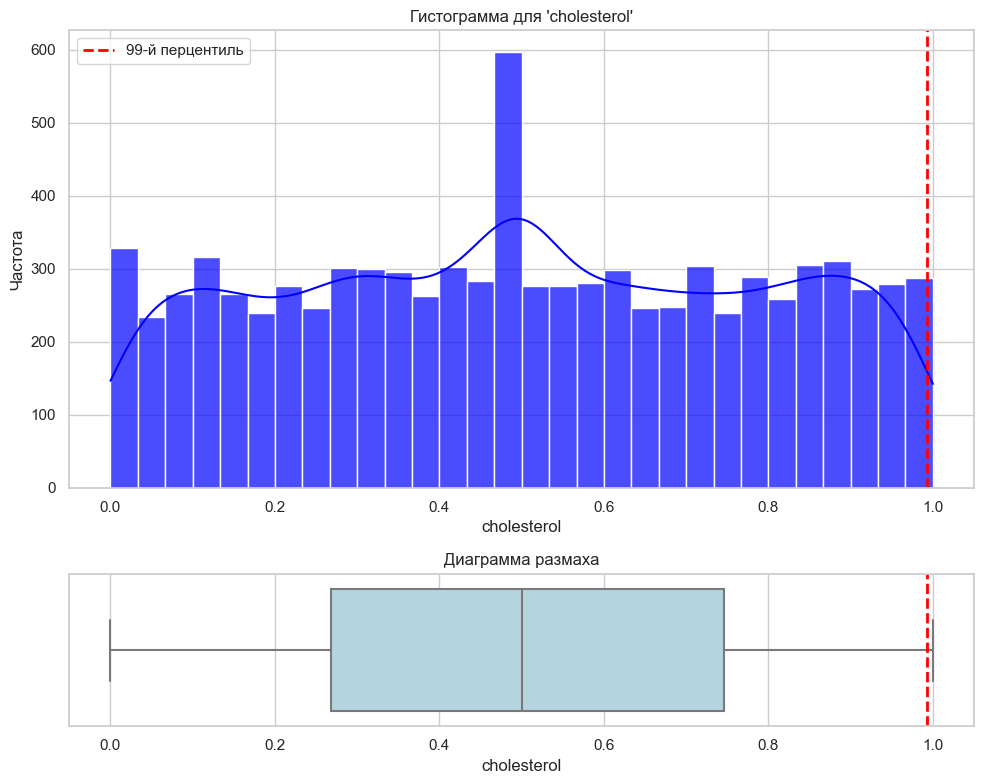


Статистика для 'heart_rate':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.02
99-й перцентиль: 0.08
Количество значений выше 99-го перцентиля: 41
Доля значений выше 99-го перцентиля: 0.47%


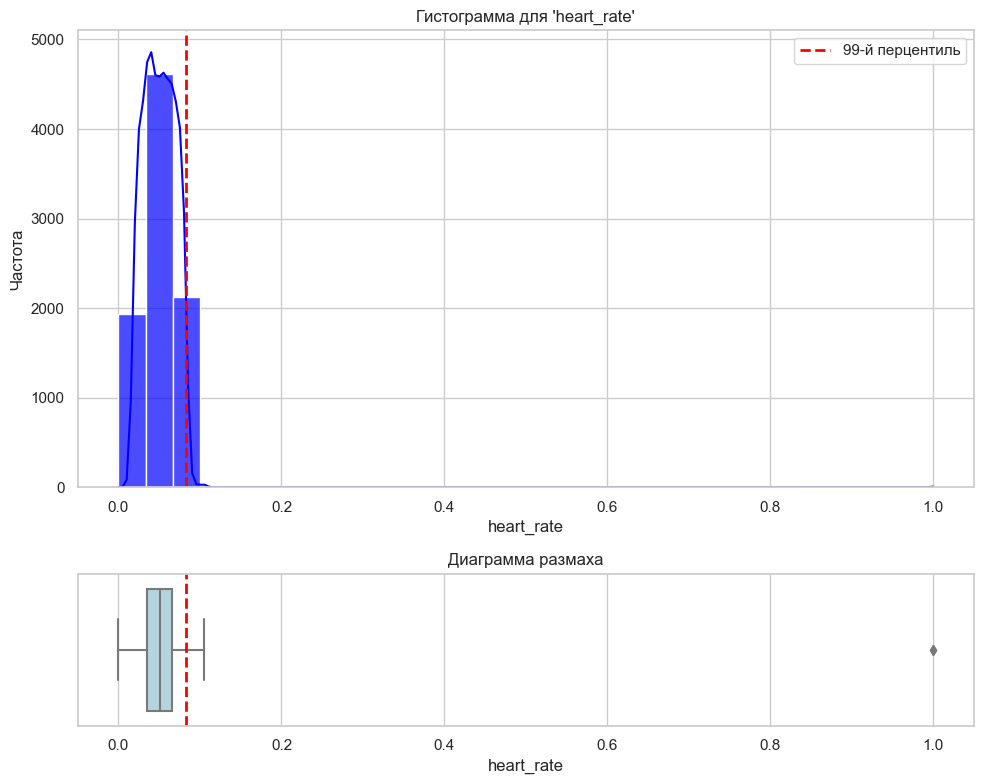


Статистика для 'exercise_hours_per_week':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 87
Доля значений выше 99-го перцентиля: 1.00%


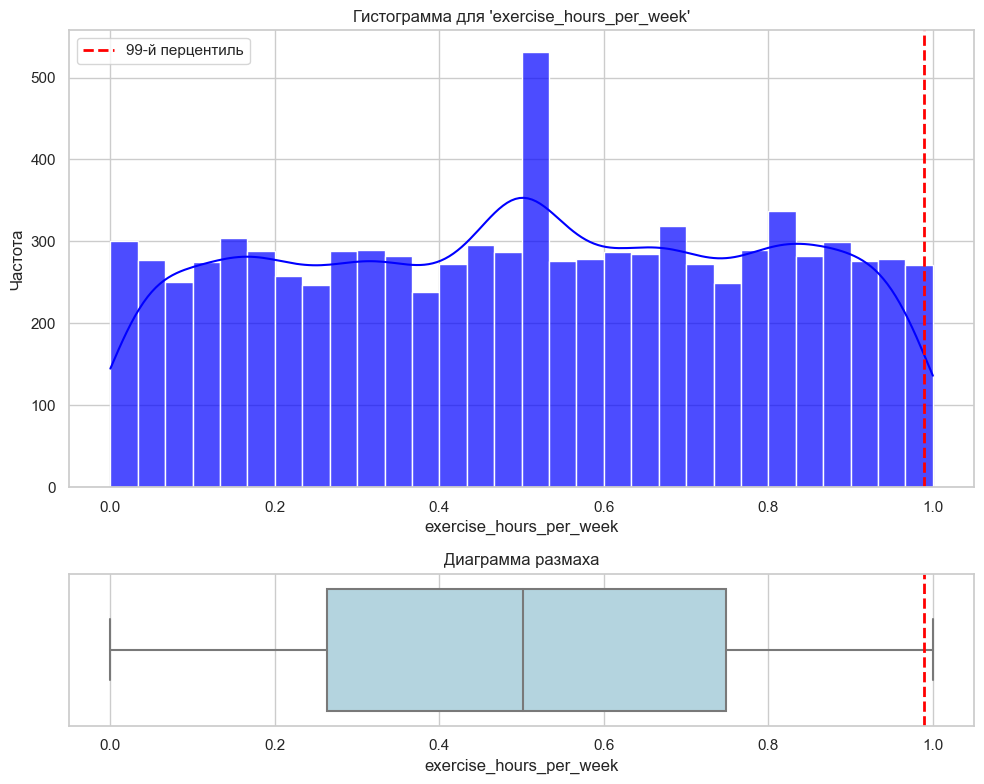


Статистика для 'sedentary_hours_per_day':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.29
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 87
Доля значений выше 99-го перцентиля: 1.00%


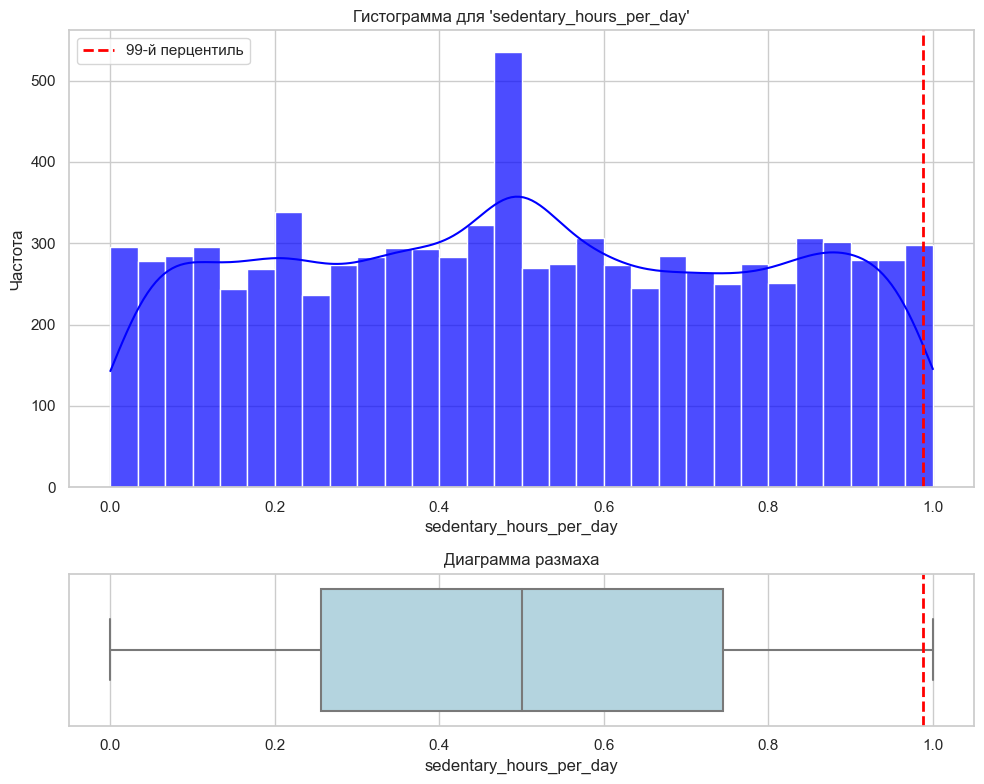


Статистика для 'income':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 87
Доля значений выше 99-го перцентиля: 1.00%


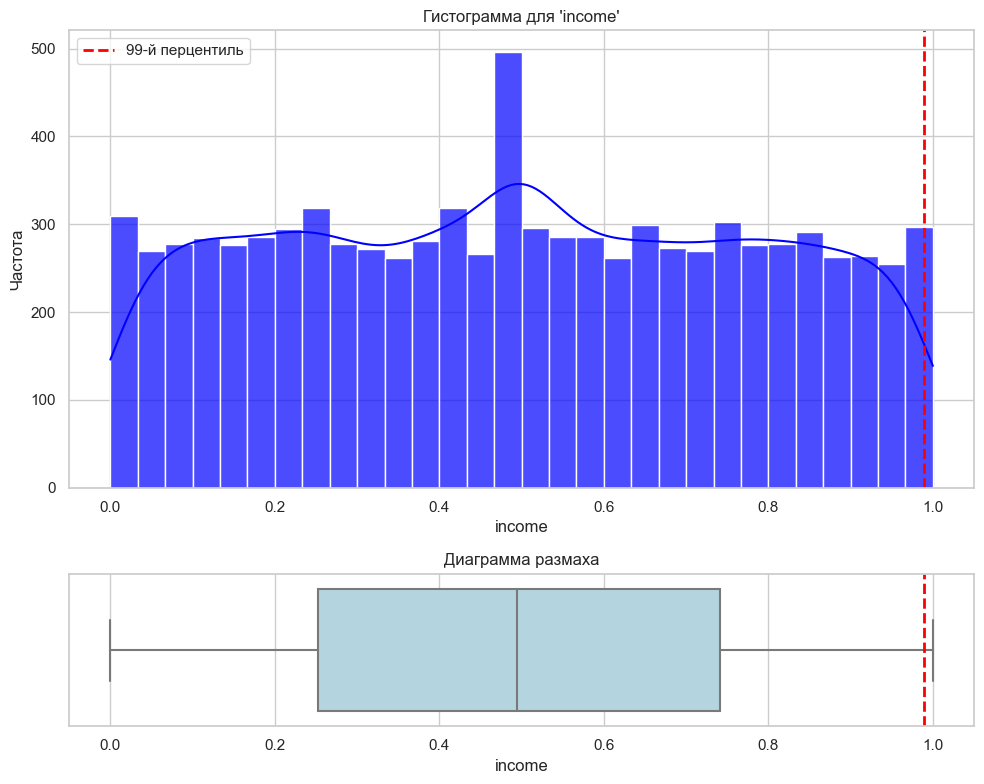


Статистика для 'bmi':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 87
Доля значений выше 99-го перцентиля: 1.00%


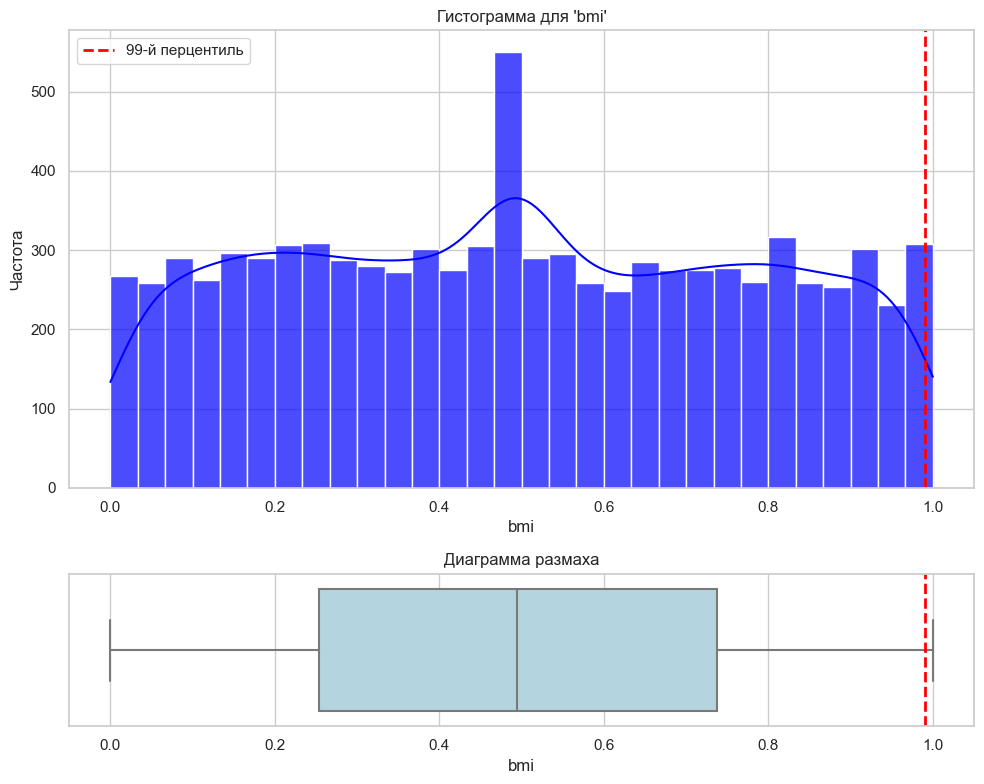


Статистика для 'triglycerides':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.29
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 81
Доля значений выше 99-го перцентиля: 0.93%


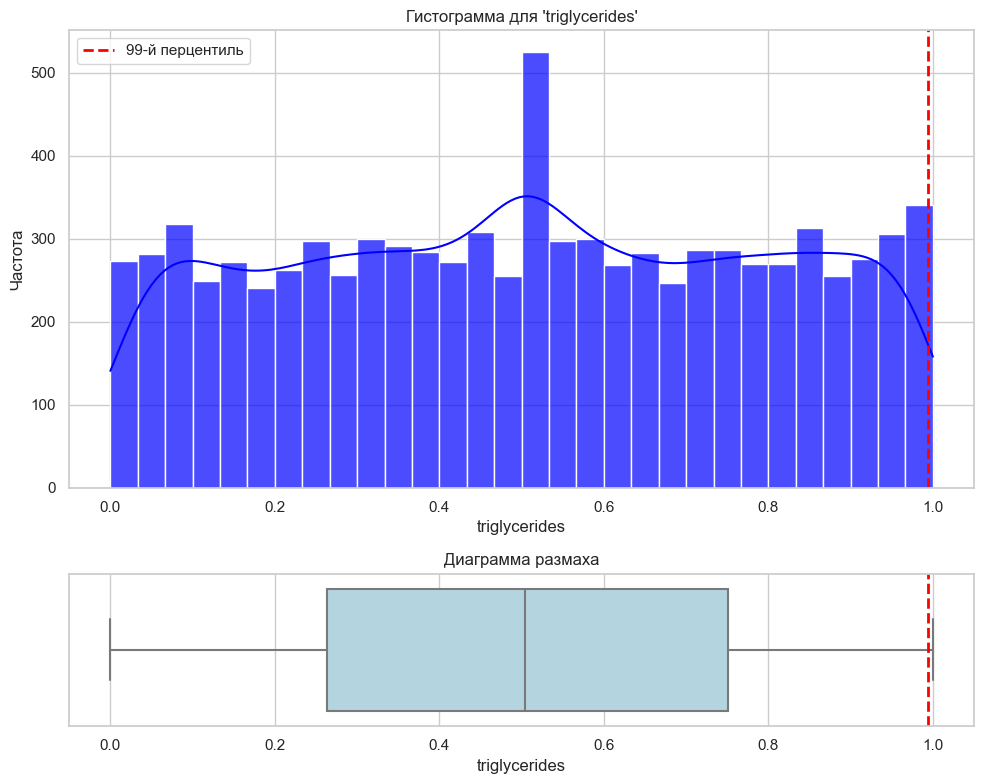


Статистика для 'sleep_hours_per_day':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.33
99-й перцентиль: 1.00
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


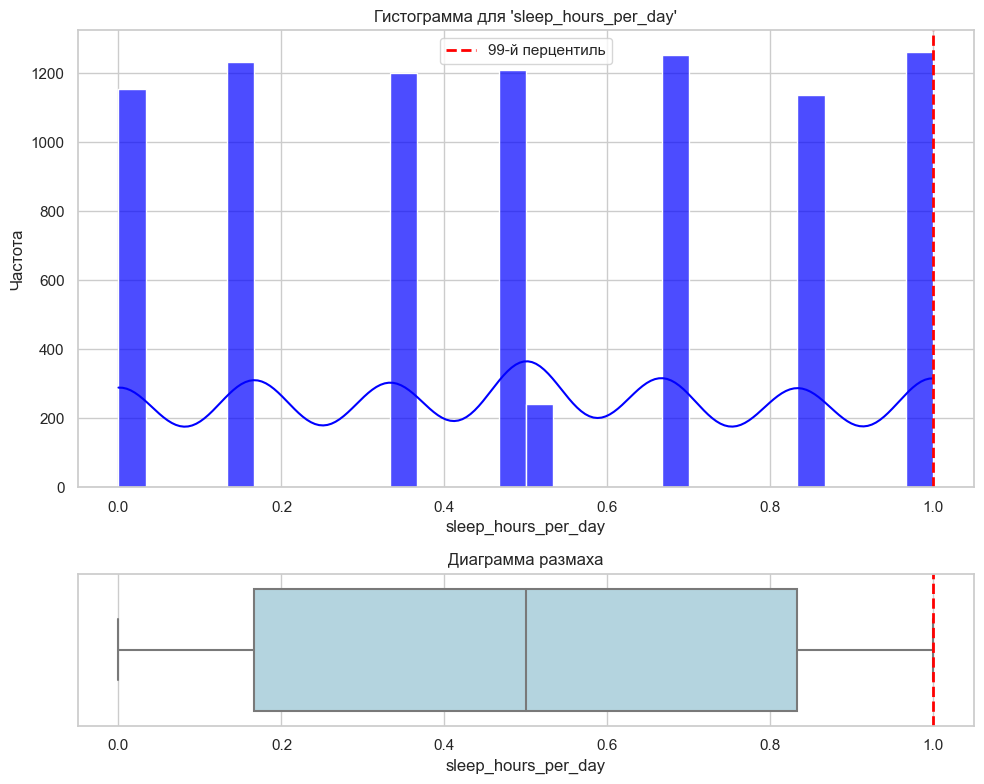


Статистика для 'blood_sugar':
Количество значений: 8685
Минимум: 0.0
Максимум: 0.9999999999999998
Среднее: 0.23
Медиана: 0.23
Стандартное отклонение: 0.08
99-й перцентиль: 0.62
Количество значений выше 99-го перцентиля: 84
Доля значений выше 99-го перцентиля: 0.97%


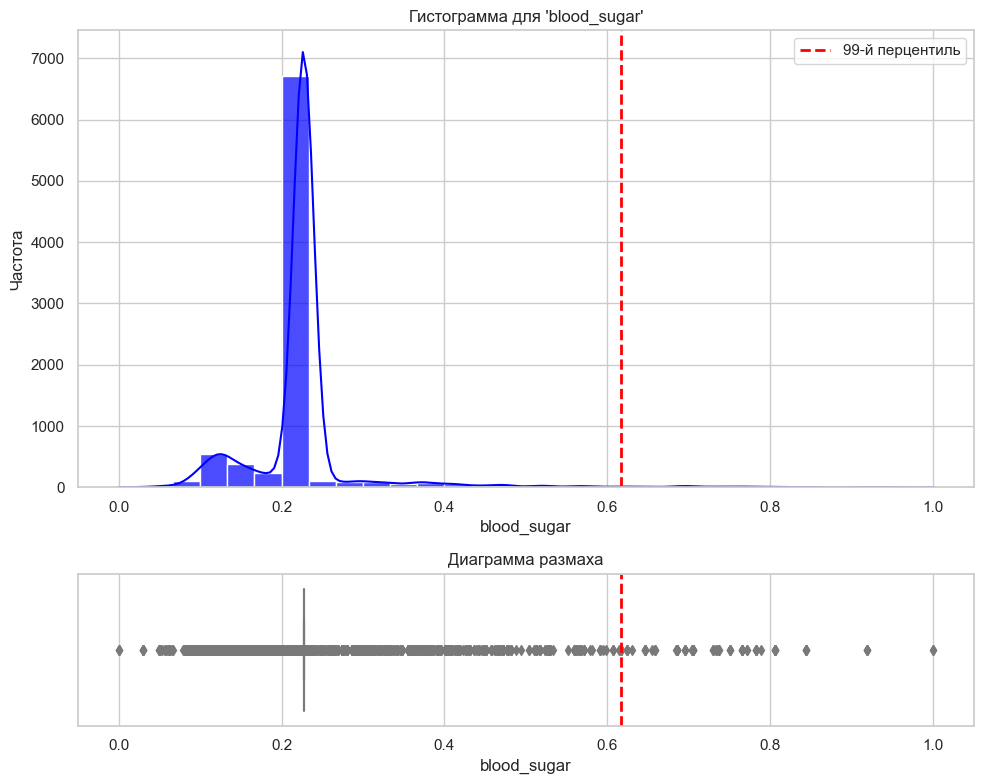


Статистика для 'ck-mb':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.08
99-й перцентиль: 0.30
Количество значений выше 99-го перцентиля: 87
Доля значений выше 99-го перцентиля: 1.00%


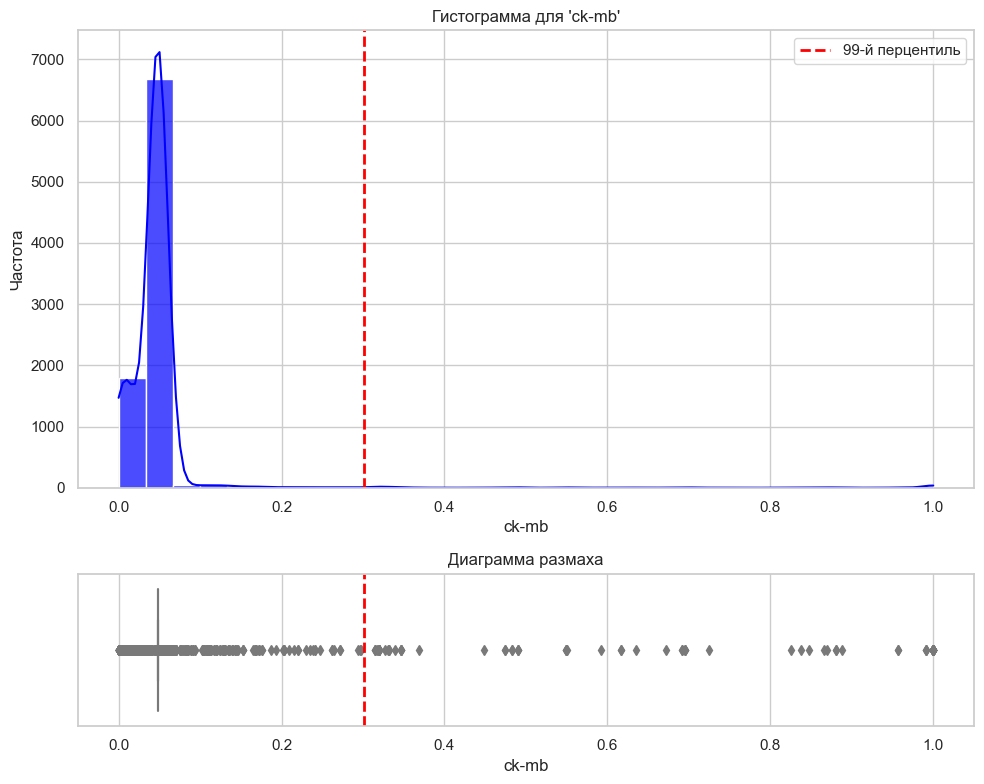


Статистика для 'troponin':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.04
Медиана: 0.04
Стандартное отклонение: 0.06
99-й перцентиль: 0.23
Количество значений выше 99-го перцентиля: 86
Доля значений выше 99-го перцентиля: 0.99%


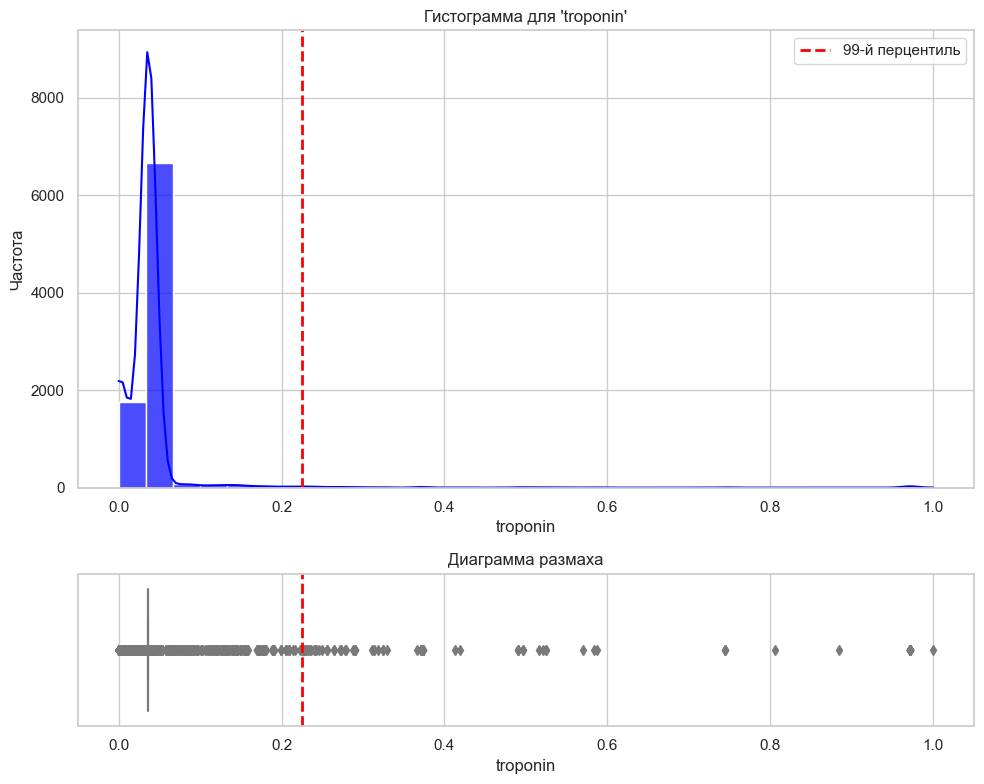


Статистика для 'systolic_blood_pressure':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.45
Медиана: 0.45
Стандартное отклонение: 0.17
99-й перцентиль: 0.74
Количество значений выше 99-го перцентиля: 5
Доля значений выше 99-го перцентиля: 0.06%


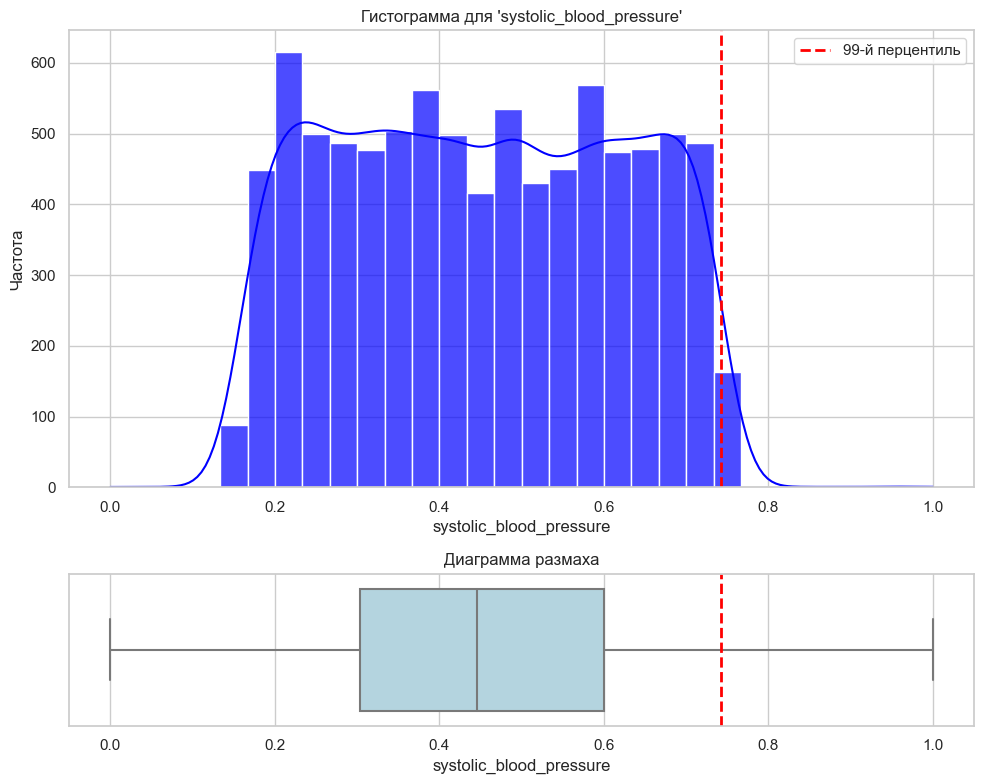


Статистика для 'diastolic_blood_pressure':
Количество значений: 8685
Минимум: 0.0
Максимум: 1.0
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.17
99-й перцентиль: 0.79
Количество значений выше 99-го перцентиля: 1
Доля значений выше 99-го перцентиля: 0.01%


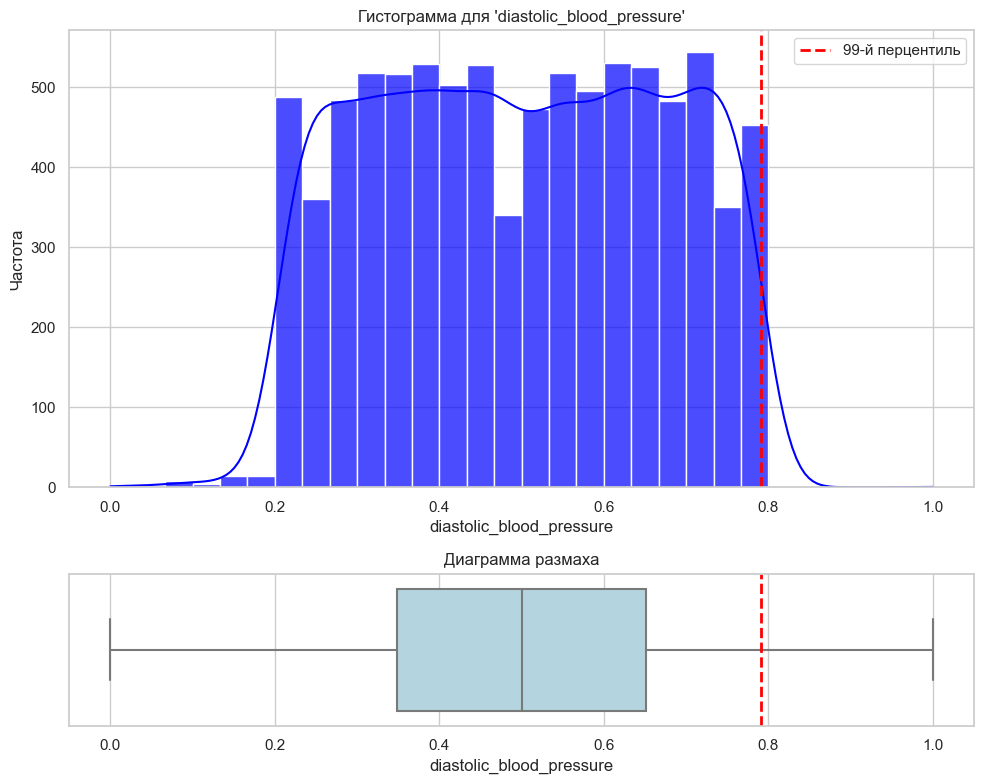

In [20]:
for feature in num_features:
    show_hist(data_train, feature)

Все числовые признаки в датасете предварительно прошли нормализацию в диапазон [0,1], что указывает на использование масштабирования, вероятно, методом MinMaxScaler или аналогичным.

Минимальные и максимальные значения признаков совпадают с 0 и 1 (или близки к ним с учётом численных ошибок вычислений).

Средние и медианные значения большинства признаков находятся около 0.5, что подтверждает равномерное распределение после нормализации.

Стандартное отклонение для большинства признаков колеблется в пределах 0.17–0.33, что характерно для масштабированных данных.

В некоторых признаках наблюдаются значения, равные 1 или близкие к нему (например, exercise_hours_per_week, sedentary_hours_per_day, bmi), при этом доля таких значений достигает 1% — это может быть связано с наличием верхних границ по исходным измерениям.

Перцентиль 99% для большинства признаков близок к 1, а значения выше него встречаются редко (менее 1% выборки), что указывает на слабое влияние выбросов после нормализации.

## Анализ категориальных признаков

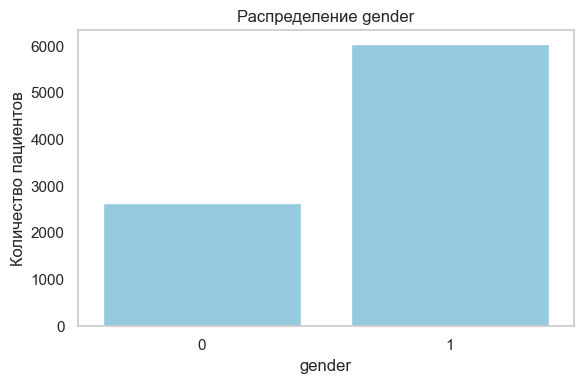

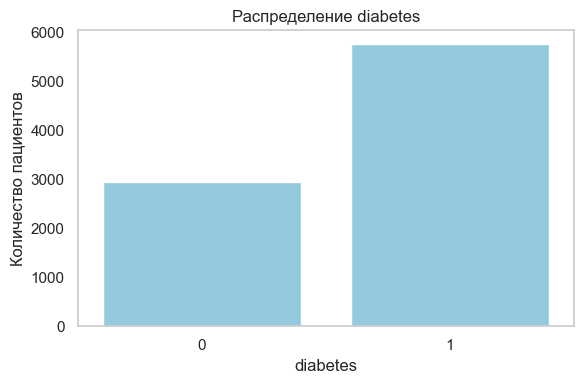

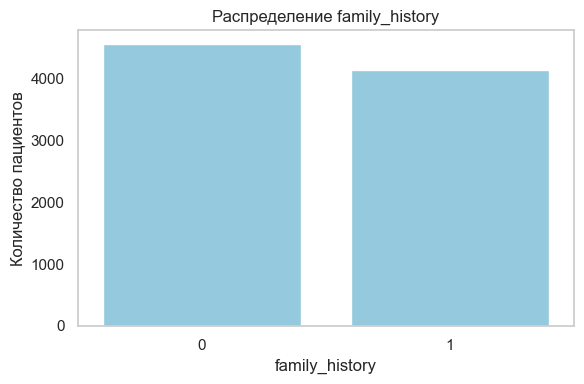

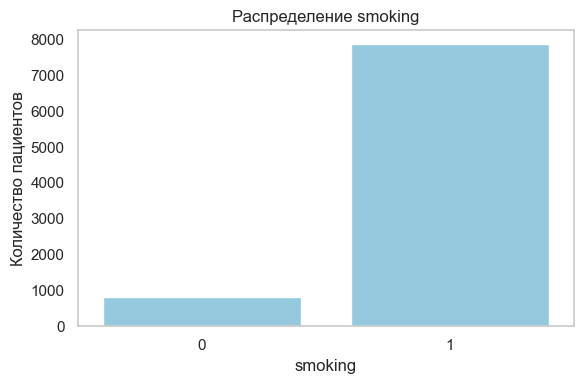

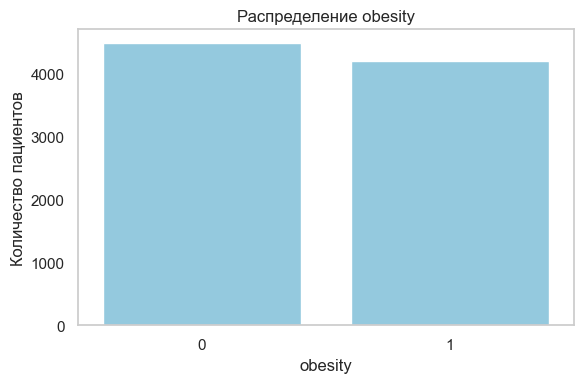

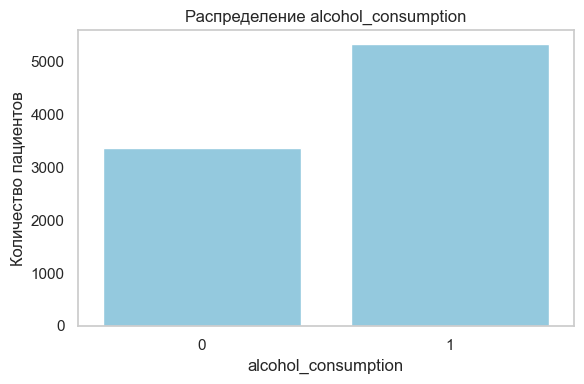

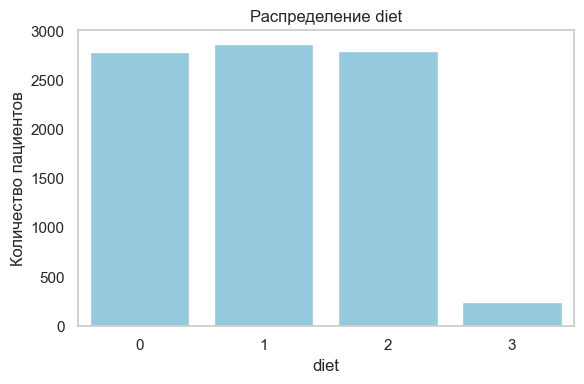

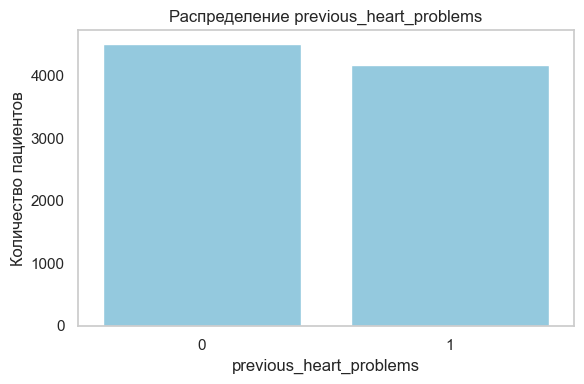

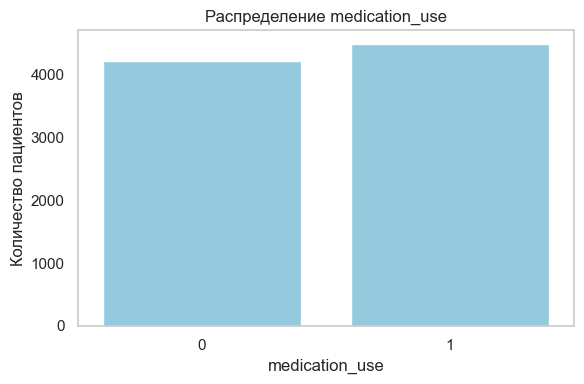

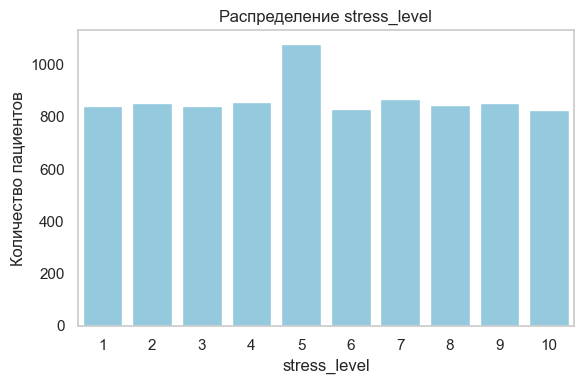

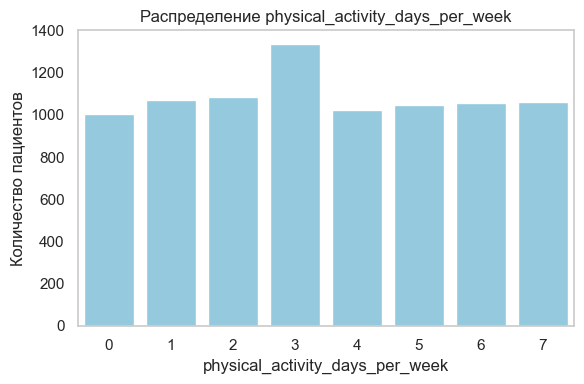

In [24]:
for feature in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data_train, x=f'{feature}', color='skyblue')
    
    plt.title(f"Распределение {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Количество пациентов")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

По полученным графикам мы видим:
- Большая часть пациентов - мужчины
- Диабетиков в 2 раза больше
- У большей части в семейном анамнезе не было пролем с сердцем
- Подавляющее количество курящих (примерно 90%)
- Пациентов с ожирением немного меньше половины
- Около 60% пациентов употребляют алкоголь
- Пациенты почти равномерно распределены между категориями diet 0, 1 и 2, тогда как diet 3 — редкий случай. Это может говорить о том, что данный тип диеты связан с особыми условиями или ограничениями.
- Почти у половины наблюдались проблемы с сердцем в прошлом
- Больше половины употребляют лекарства
- Наиболее часто встречающийся уровень стресса среди пациентов — средний (5). Остальные уровни встречаются с примерно одинаковой частотой
- Чаще всего пациенты занимаются физической активностью 3 раза в неделю, что соответствует популярным рекомендациям по поддержанию здоровья. Остальные варианты встречаются примерно с одинаковой частотой.

## Корреляция признаков с целевой переменной

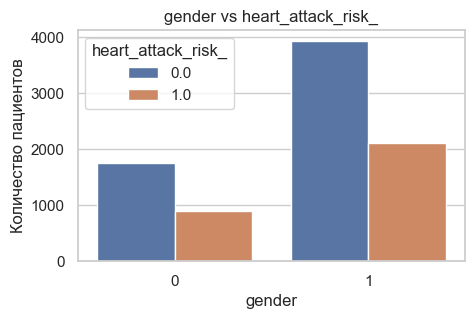

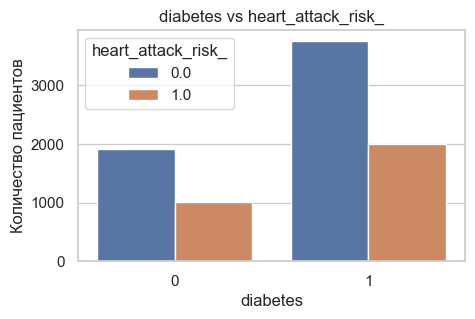

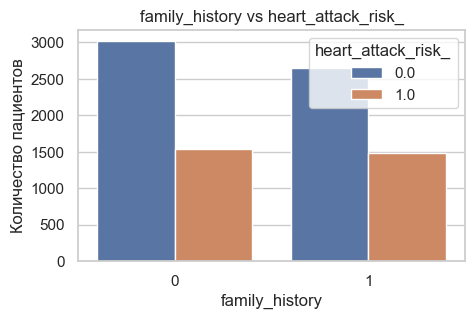

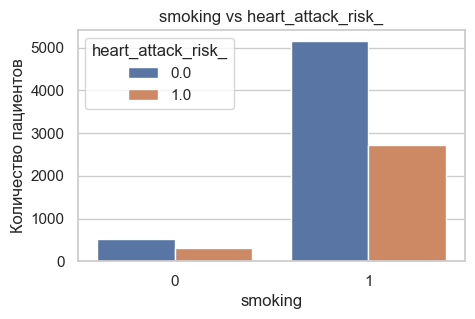

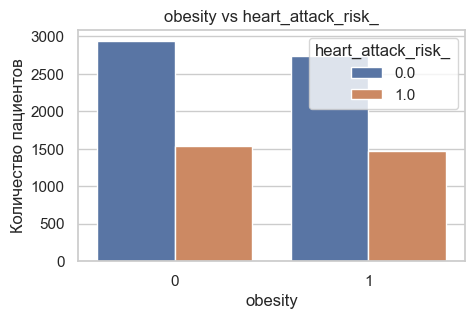

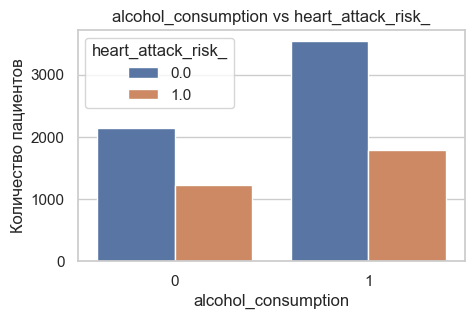

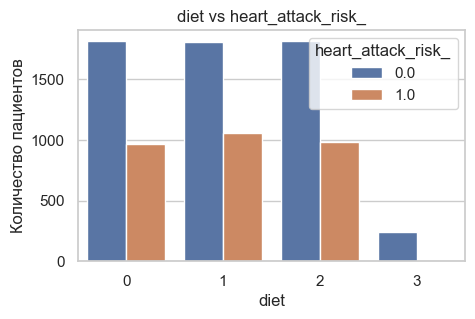

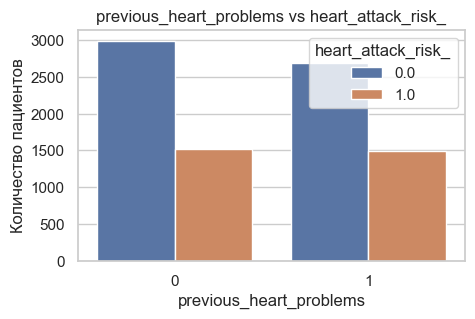

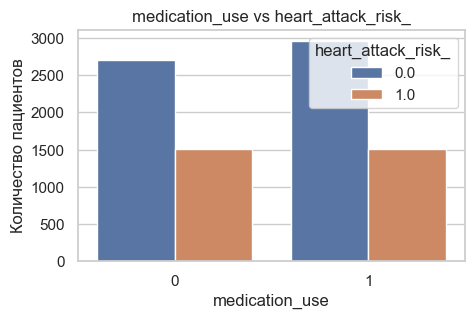

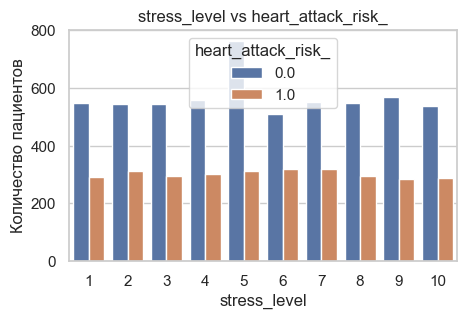

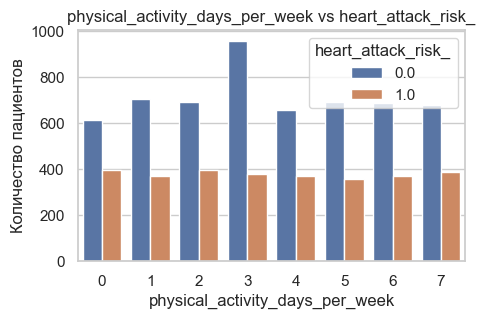

In [25]:
for col in cat_features:
    plt.figure(figsize=(5,3))
    sns.countplot(data=data_train, x=col, hue=target)
    plt.title(f'{col} vs {target}')
    plt.ylabel("Количество пациентов")
    plt.show()

 Наиболее значимые факторы риска: мужской пол, диабет, семейная предрасположенность, курение, ожирение, предыдущие сердечные проблемы.
 - Умеренные факторы: употребление алкоголя, приём медикаментов (как маркер уже существующих проблем).
 - Слабые или неоднозначные факторы: диета, стресс, количество дней физической активности.
 - Профиль пациента с наибольшим риском: мужчина, курильщик, с диабетом, ожирением, семейной предрасположенностью, уже имевший сердечные проблемы, с низкой физической активностью.

## Анализ данных data_test

## Анализ числовых признаков


Статистика для 'age':
Количество значений: 966
Минимум: 0.0449438202247191
Максимум: 0.853932584269663
Среднее: 0.45
Медиана: 0.46
Стандартное отклонение: 0.23
99-й перцентиль: 0.85
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


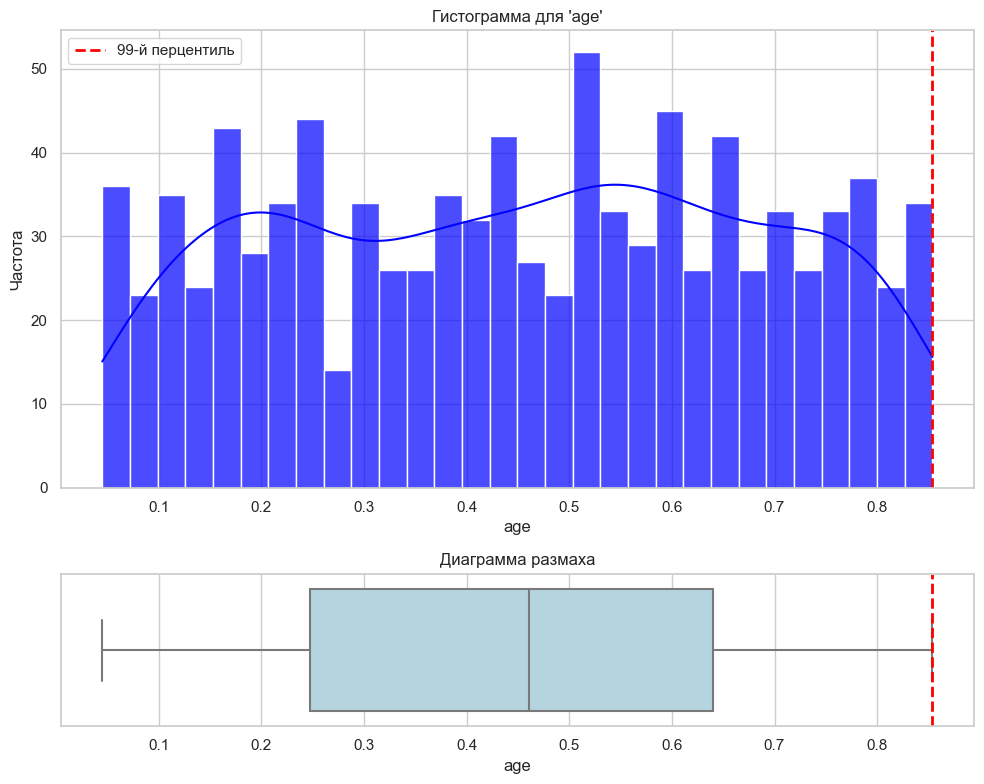


Статистика для 'cholesterol':
Количество значений: 966
Минимум: 0.0
Максимум: 0.9964285714285714
Среднее: 0.49
Медиана: 0.50
Стандартное отклонение: 0.28
99-й перцентиль: 0.98
Количество значений выше 99-го перцентиля: 9
Доля значений выше 99-го перцентиля: 0.93%


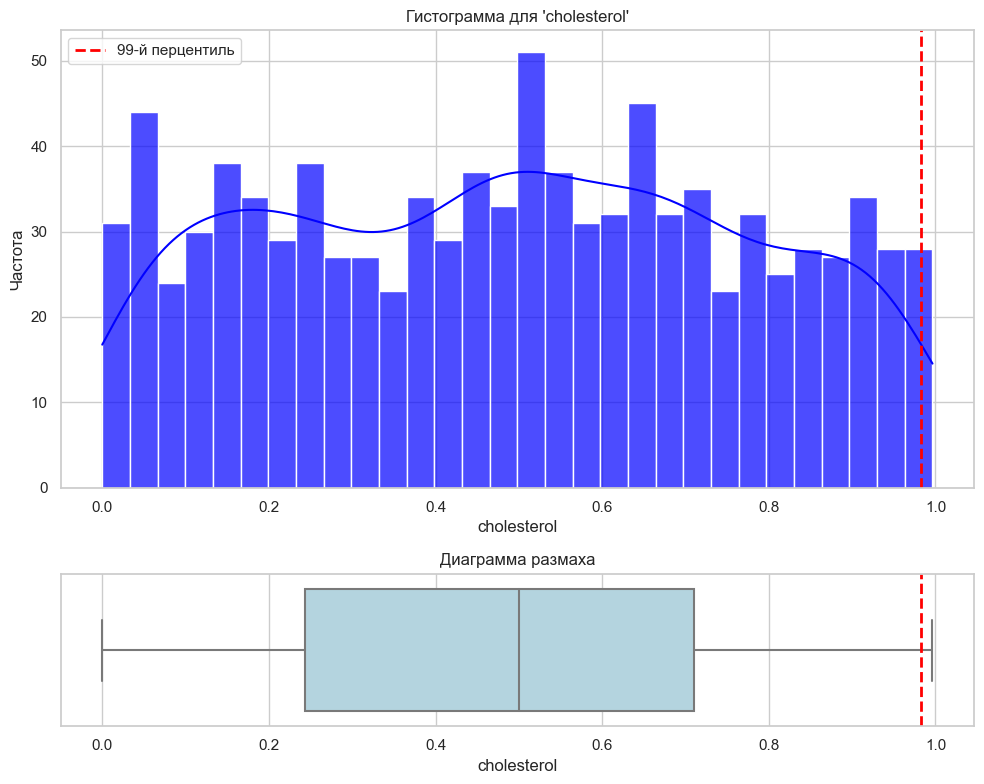


Статистика для 'heart_rate':
Количество значений: 966
Минимум: 0.0
Максимум: 1.0
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.04
99-й перцентиль: 0.08
Количество значений выше 99-го перцентиля: 5
Доля значений выше 99-го перцентиля: 0.52%


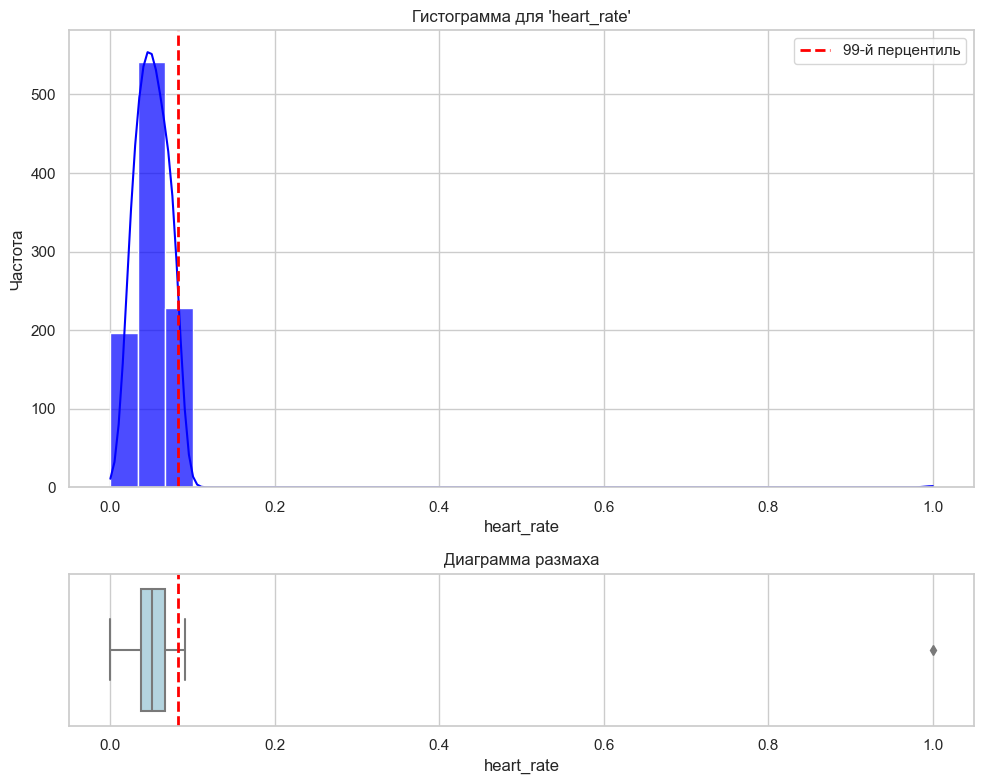


Статистика для 'exercise_hours_per_week':
Количество значений: 966
Минимум: 0.0003358955492129
Максимум: 0.9989384698335876
Среднее: 0.49
Медиана: 0.50
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


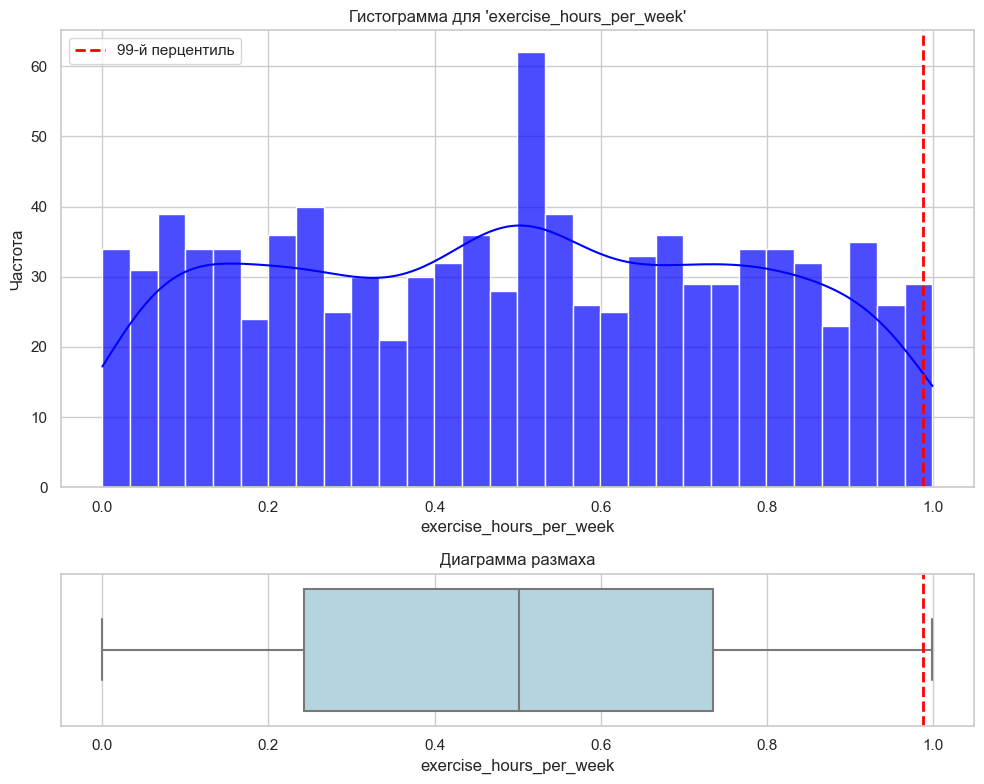


Статистика для 'sedentary_hours_per_day':
Количество значений: 966
Минимум: 0.0011868749977401
Максимум: 0.9990334233495732
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.29
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


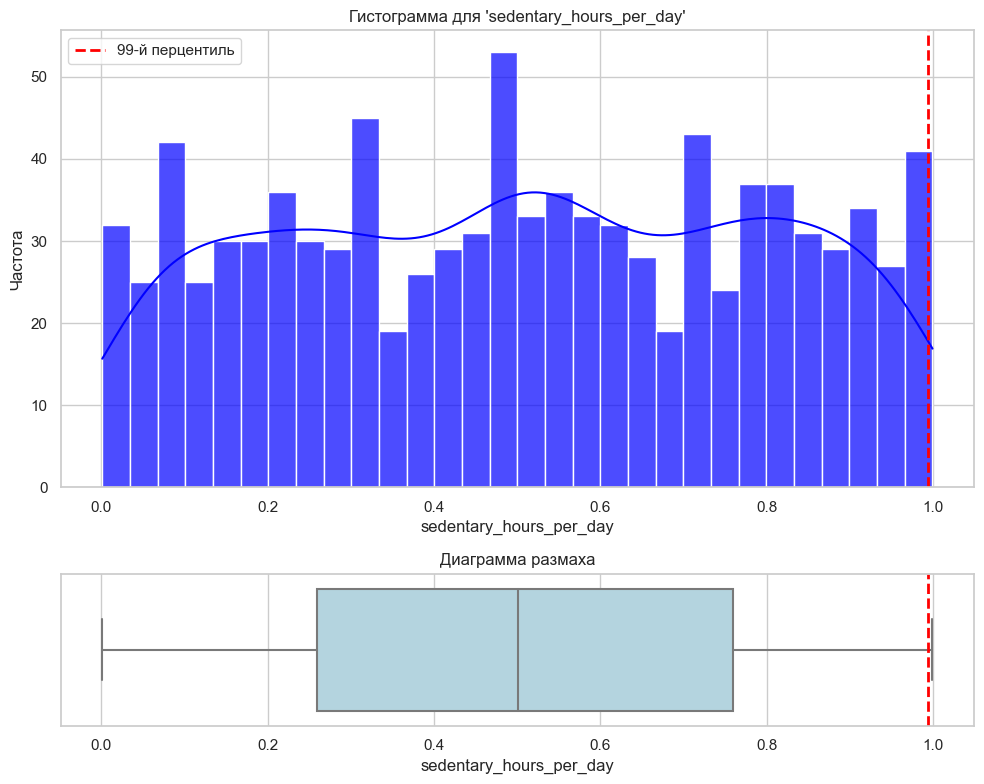


Статистика для 'income':
Количество значений: 966
Минимум: 0.0033512926414474
Максимум: 0.9988852843239534
Среднее: 0.48
Медиана: 0.49
Стандартное отклонение: 0.27
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


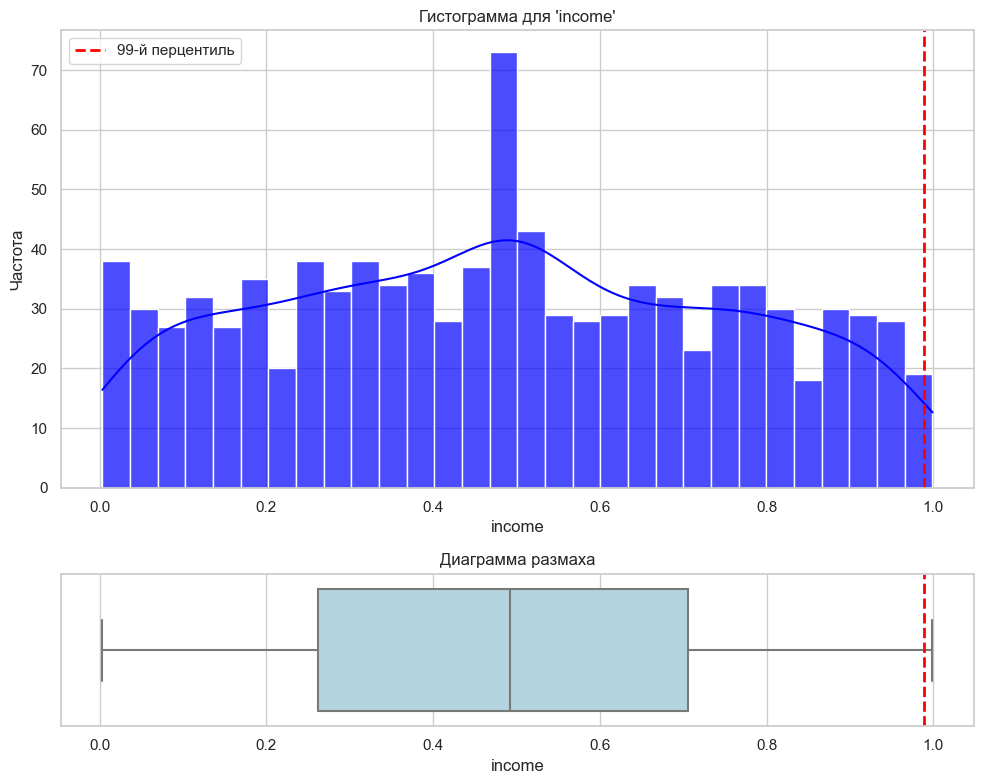


Статистика для 'bmi':
Количество значений: 966
Минимум: 0.0025976350950317
Максимум: 0.999496058164343
Среднее: 0.48
Медиана: 0.47
Стандартное отклонение: 0.29
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


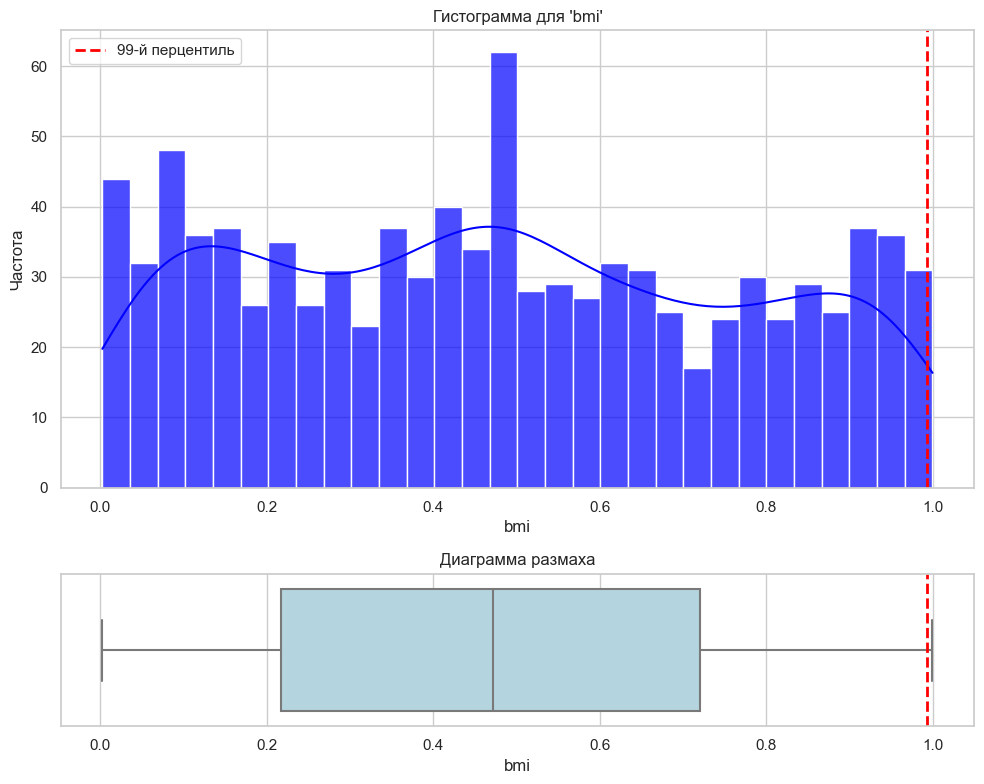


Статистика для 'triglycerides':
Количество значений: 966
Минимум: 0.0
Максимум: 0.9987012987012988
Среднее: 0.49
Медиана: 0.49
Стандартное отклонение: 0.28
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 7
Доля значений выше 99-го перцентиля: 0.72%


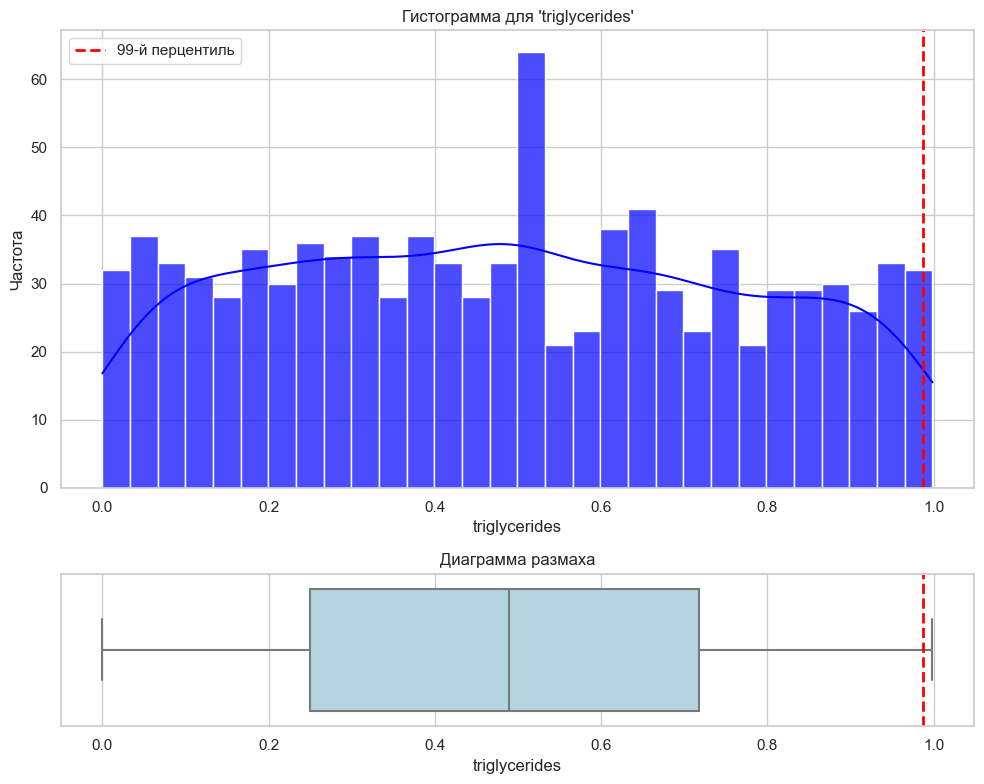


Статистика для 'sleep_hours_per_day':
Количество значений: 966
Минимум: 0.0
Максимум: 1.0
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.32
99-й перцентиль: 1.00
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


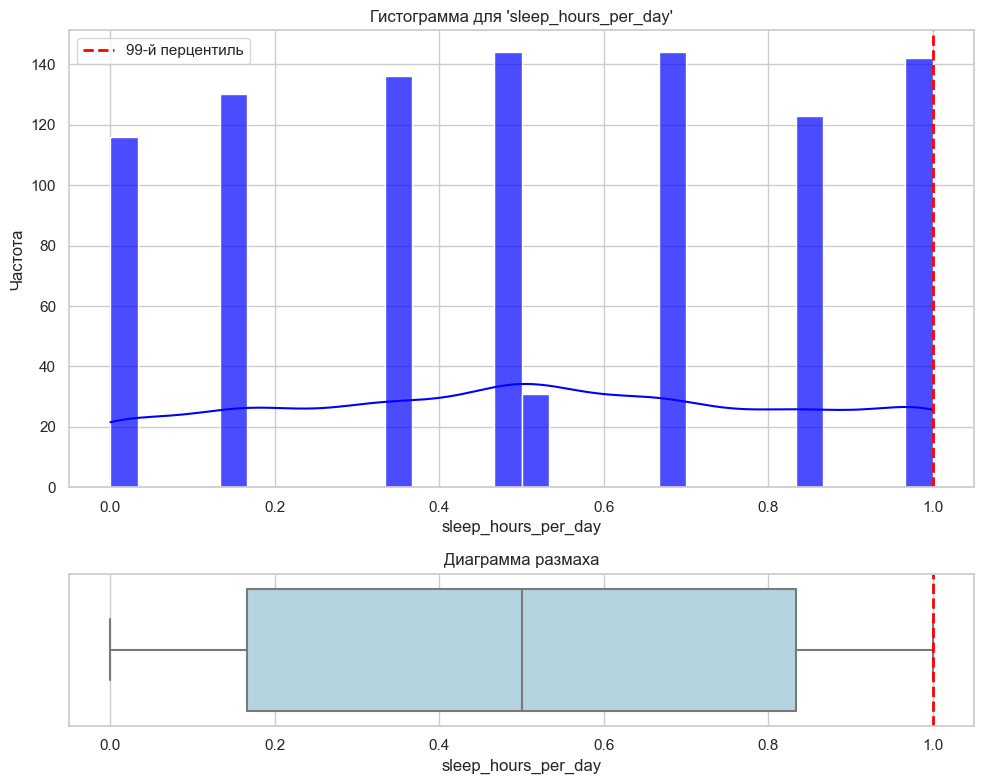


Статистика для 'blood_sugar':
Количество значений: 966
Минимум: 0.0296442687747035
Максимум: 0.75098814229249
Среднее: 0.22
Медиана: 0.23
Стандартное отклонение: 0.07
99-й перцентиль: 0.52
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


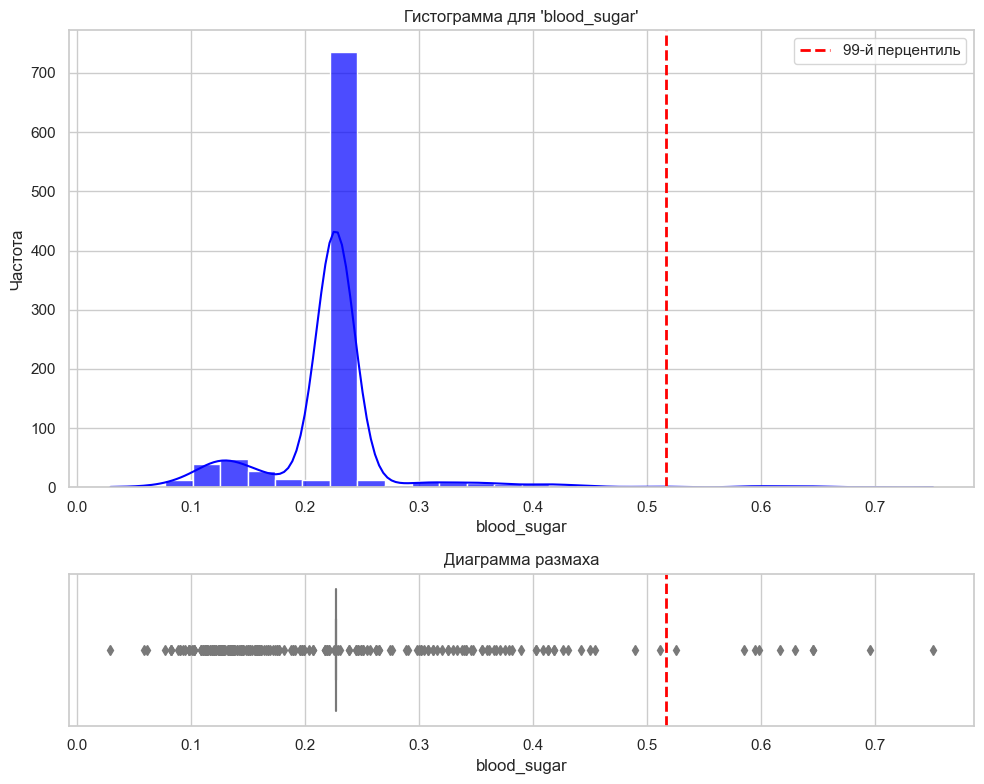


Статистика для 'ck-mb':
Количество значений: 966
Минимум: 0.0
Максимум: 1.0
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.08
99-й перцентиль: 0.33
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


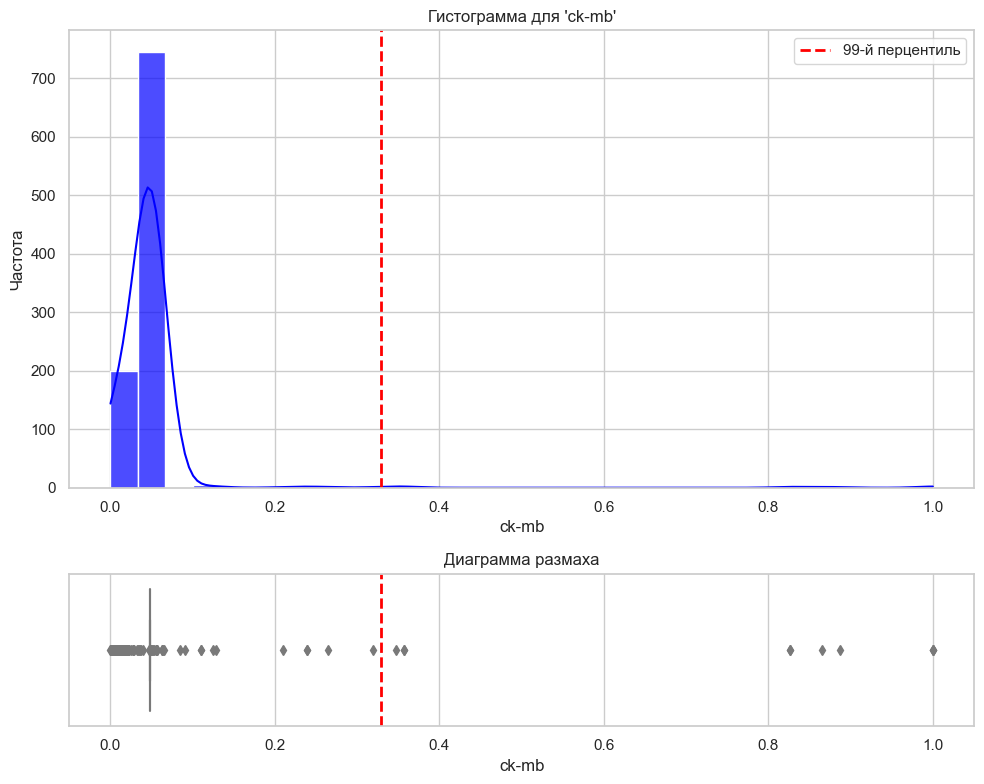


Статистика для 'troponin':
Количество значений: 966
Минимум: 0.0001941936110301
Максимум: 0.9708709583454704
Среднее: 0.03
Медиана: 0.04
Стандартное отклонение: 0.05
99-й перцентиль: 0.16
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


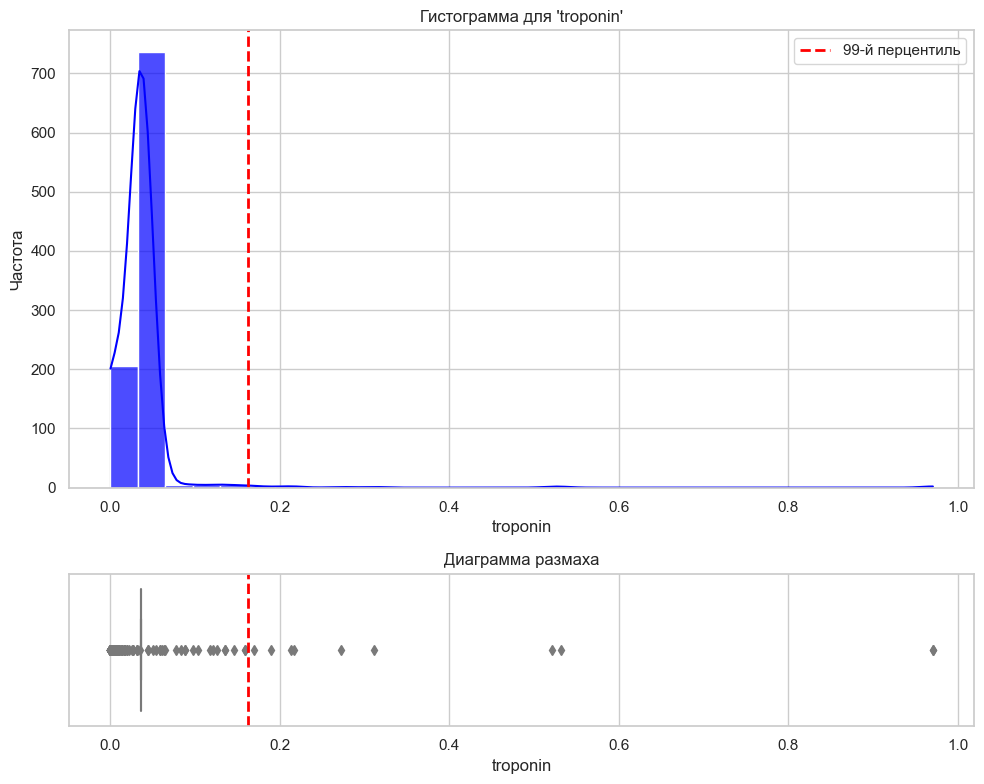


Статистика для 'systolic_blood_pressure':
Количество значений: 966
Минимум: 0.0129032258064515
Максимум: 0.7419354838709677
Среднее: 0.45
Медиана: 0.45
Стандартное отклонение: 0.17
99-й перцентиль: 0.74
Количество значений выше 99-го перцентиля: 10
Доля значений выше 99-го перцентиля: 1.04%


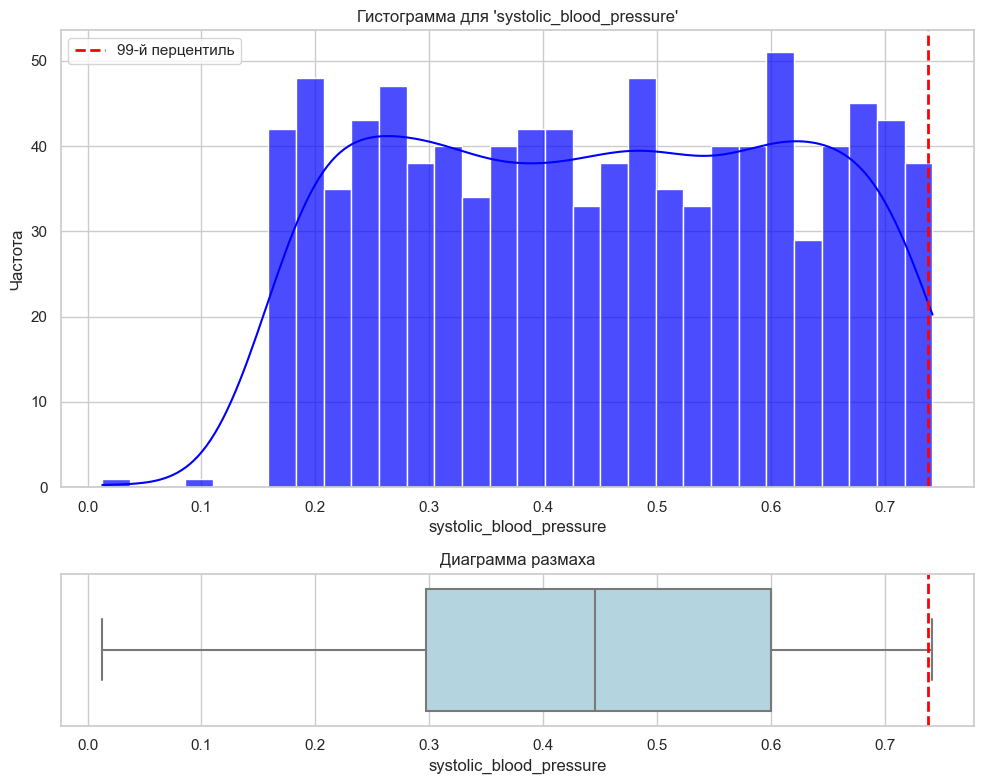


Статистика для 'diastolic_blood_pressure':
Количество значений: 966
Минимум: 0.1162790697674418
Максимум: 0.7906976744186047
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.17
99-й перцентиль: 0.79
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


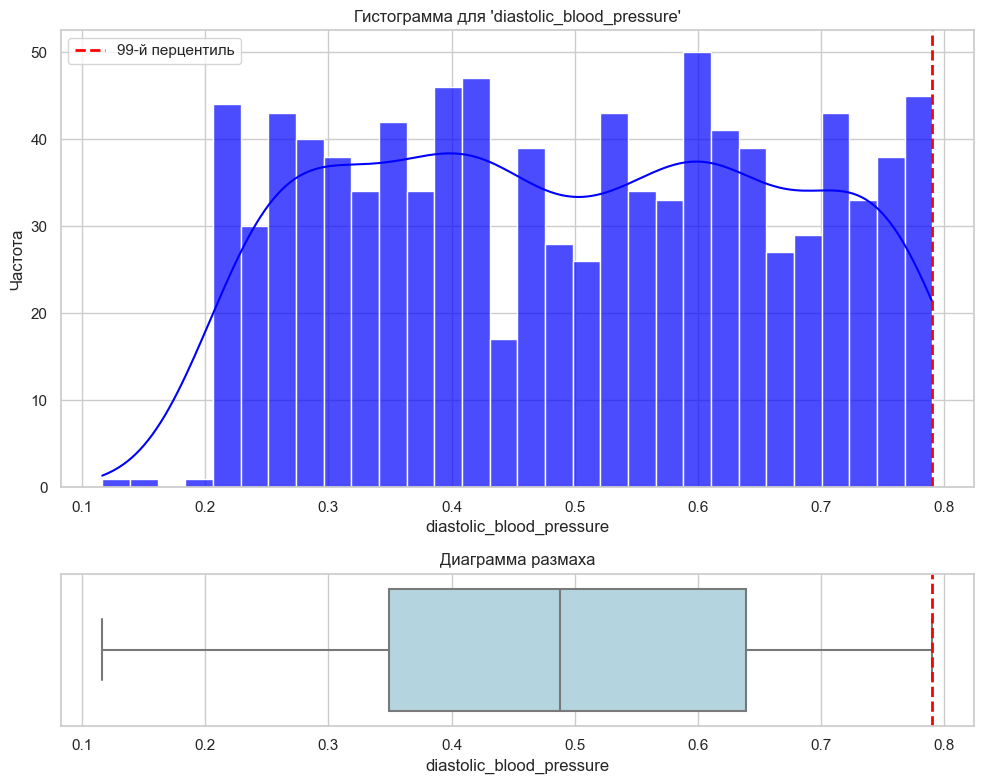

In [26]:
for feature in num_features:
    show_hist(data_test, feature)

## Анализ категориальных признаков

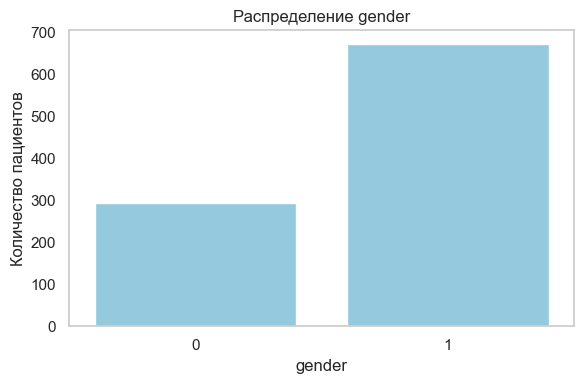

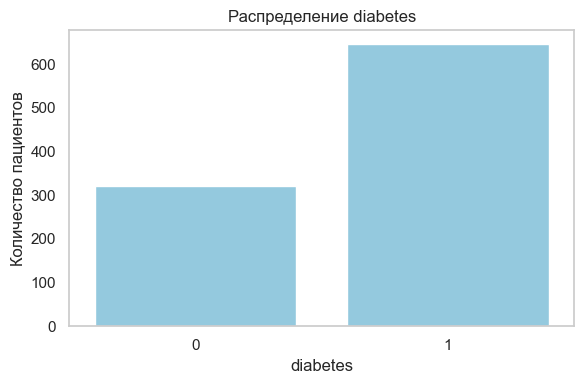

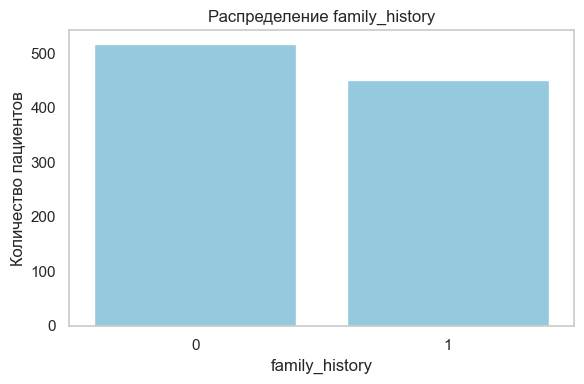

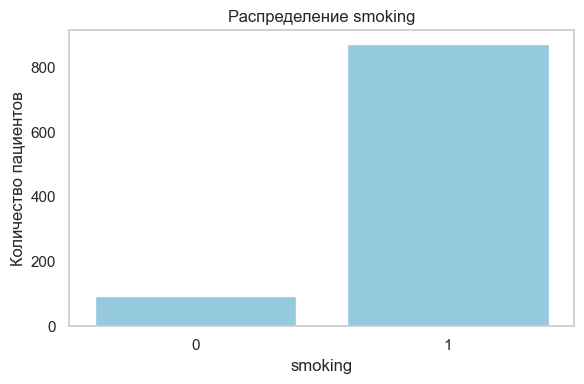

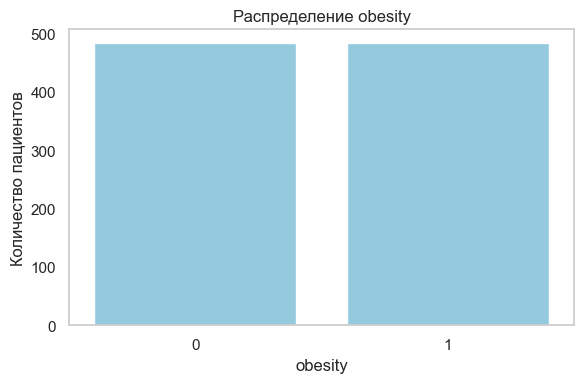

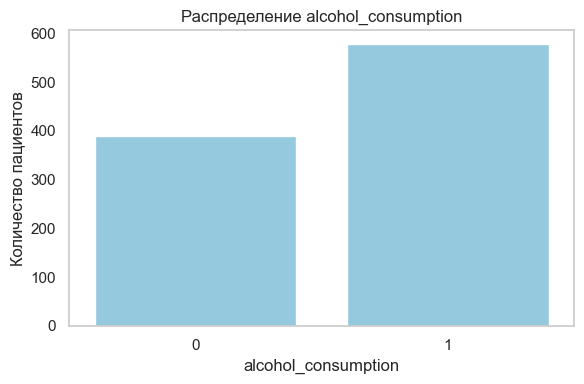

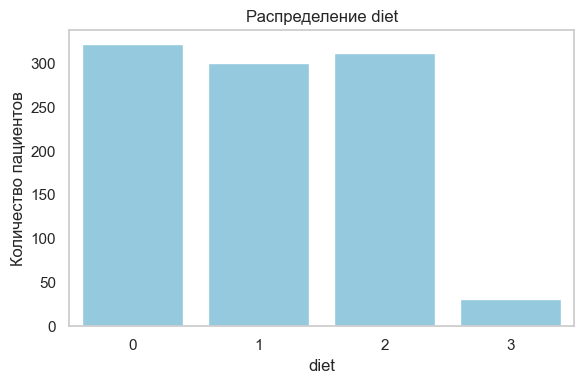

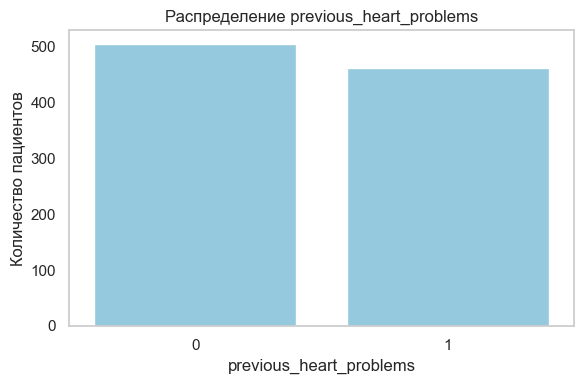

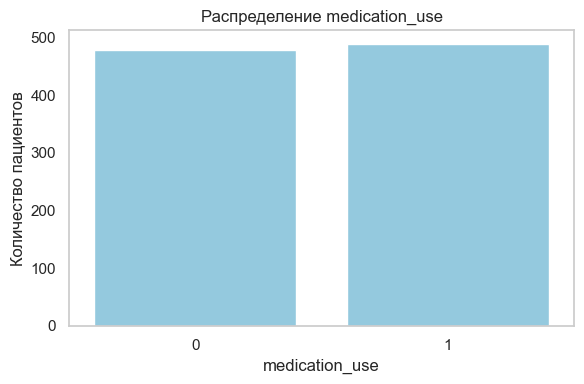

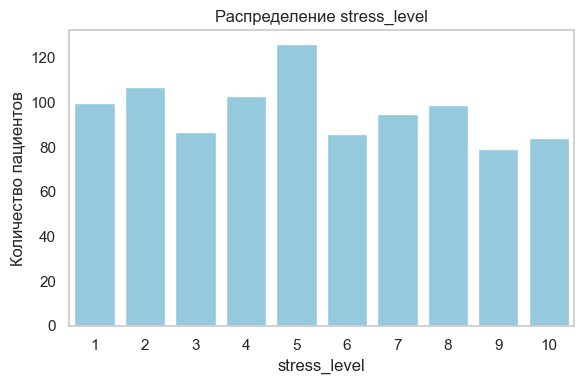

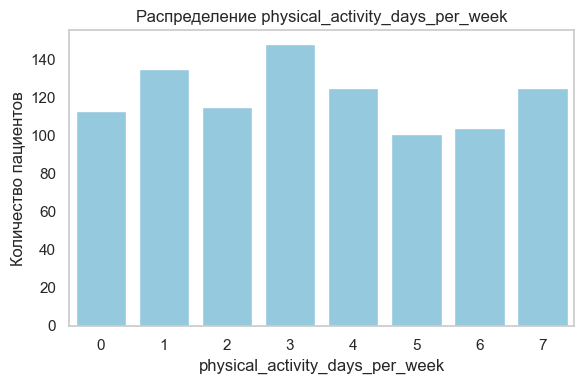

In [27]:
for feature in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data_test, x=f'{feature}', color='skyblue')
    
    plt.title(f"Распределение {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Количество пациентов")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Промежуточный вывод

В ходе EDA установлено, что все числовые признаки в датасете прошли предварительное масштабирование в диапазон [0, 1], вероятно с использованием MinMaxScaler или аналогичного метода.
Распределения большинства признаков близки к равномерным, средние и медианные значения находятся около 0.5, а стандартные отклонения лежат в диапазоне 0.17–0.33. Наличие отдельных значений, близких к 1 (до 1% выборки), отражает верхние границы исходных измерений. Выбросы после нормализации имеют минимальное влияние.

Анализ бинарных и категориальных признаков показал, что:

- Наиболее выраженные факторы, связанные с повышенным риском сердечного приступа: мужской пол, наличие диабета, семейная предрасположенность, курение, ожирение, предыдущие сердечные проблемы.

- Умеренное влияние наблюдается у признаков: употребление алкоголя, приём медикаментов (возможно, как следствие уже существующих заболеваний).

- Признаки диета, уровень стресса, частота физической активности демонстрируют слабую или неоднозначную связь с риском.

Общий профиль пациента с наибольшим риском — мужчина, курильщик, с диабетом, ожирением, наследственной предрасположенностью, уже имевший сердечные проблемы, с низким уровнем физической активности.

Распределение значений в тестовой и тренировочной выборке практически идентично.

# Корреляционный анализ

## Корреляционная матрица

interval columns not set, guessing: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_', 'blood_sugar', 'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure']


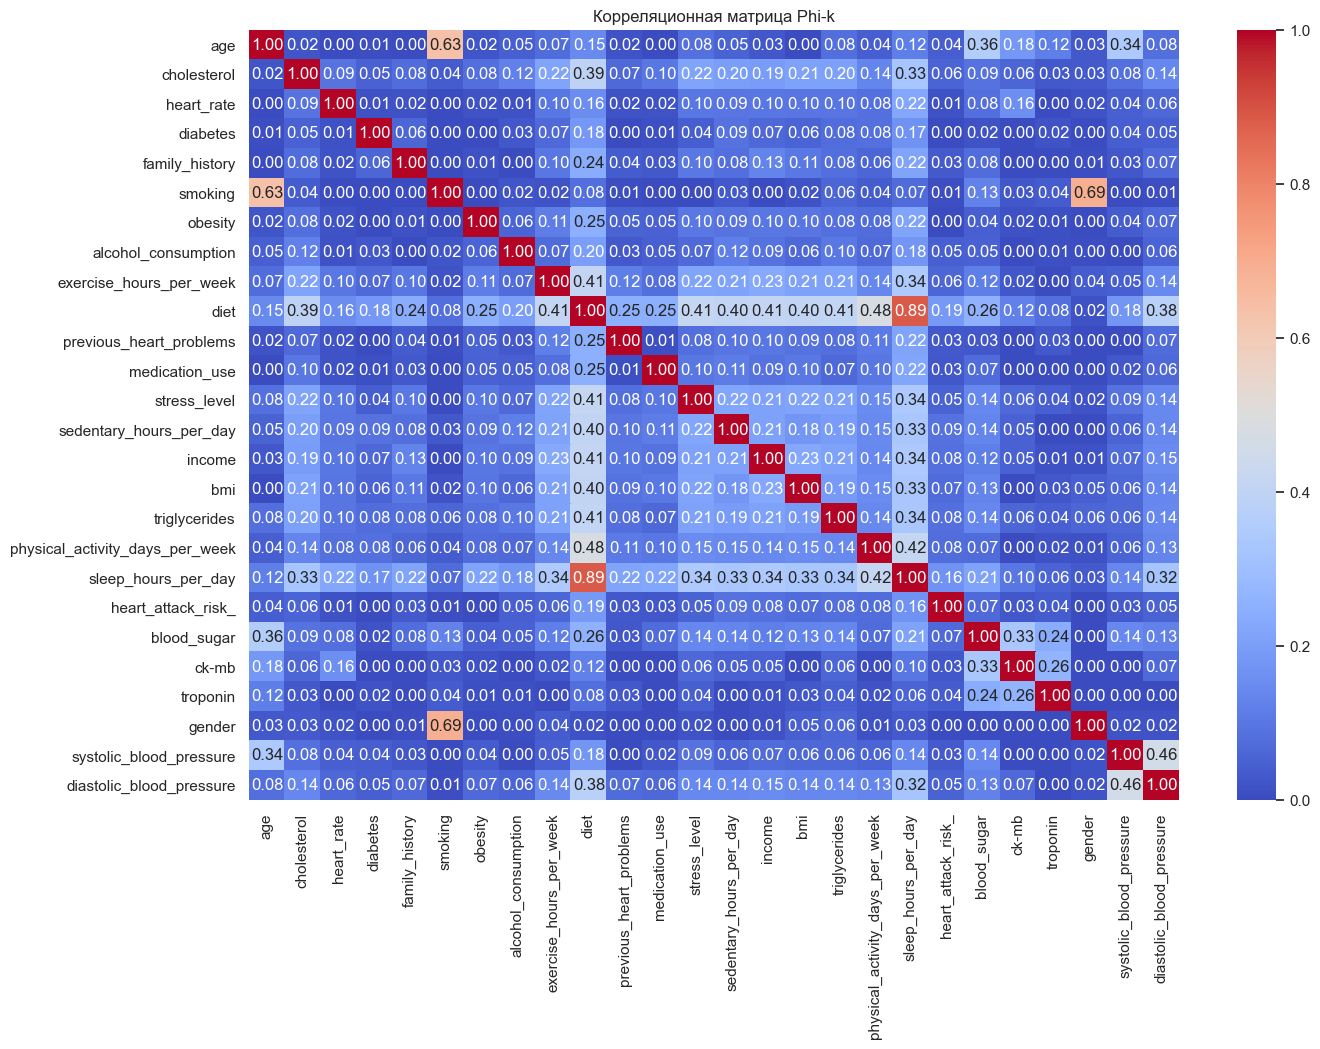

In [32]:
phik_matrix = data_train.phik_matrix()

plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Корреляционная матрица Phi-k")
plt.show()

Принято считать, что мультиколлинеарность - когда коэффициент корреляции между двумя независимыми признаками по модулю превышает 0.7 - 0.8.

## Проверка на мультиколлинеарность

In [41]:
cols_for_vif = ['smoking', 'diet', 'age', 'physical_activity_days_per_week', 'sleep_hours_per_day']
X_vif = data_train[cols_for_vif]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

vif_data = pd.DataFrame()
vif_data['Feature'] = cols_for_vif
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

vif_data

,Feature,VIF
0,smoking,1.182996
1,diet,1.000177
2,age,1.182979
3,physical_activity_days_per_week,1.000231
4,sleep_hours_per_day,1.000249


Все значения VIF ниже 2 — это значит, проблемы мультиколлинеарности в данных нет. VIF > 10 говорил бы о высокой мультиколлинеарности.

# Пайплайны

## Определение списков столбцов

In [52]:
ohe_cols = ['diabetes', 
            'family_history', 
            'smoking', 
            'obesity', 
            'alcohol_consumption', 
            'diet', 
            'previous_heart_problems', 
            'medication_use', 
            'stress_level', 
            'physical_activity_days_per_week', 
            'gender']

## Кодирование целевого признака

In [ ]:
X = data_train.drop(['heart_attack_risk_', 'ck-mb', 'troponin'], axis=1)
y = data_train['heart_attack_risk_']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [58]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8685 non-null   Int64  
 4   family_history                   8685 non-null   Int64  
 5   smoking                          8685 non-null   Int64  
 6   obesity                          8685 non-null   Int64  
 7   alcohol_consumption              8685 non-null   Int64  
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   Int64  
 10  previous_heart_problems          8685 non-null   Int64  
 11  medication_use                   8685 non-null   Int64  
 12  stress_level        